# Feature Selection : 상관성 & 다중공선성 확인
---

In [70]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [566]:
# func 모음

# 1. 종목코드를 6자리로 통일. ex) 990 -> 000990
def padding(x):
    return x.rjust(6, "0")

# 2. 낮으면 좋은 변수 역수화
def reciprocal(x):
    return 1/x

## 1-1. 상관성(샤프지수와 일일변동평균에서 존재)

In [72]:
df = pd.read_csv("./datasets/preprocessed_final.csv", index_col=0)
df["종목코드"] = df["종목코드"].astype("str")
df["종목코드"] = df["종목코드"].map(padding)
df

,종목코드,종목명,NCAV,PEGR,PSR,유동비율,부채비율,일일변동평균,샤프지수,PER,PBR,시가총액
0,000990,DB하이텍,0.028653,4.113681,2.670785,174.09,48.29,0.445142,49.648820,23.36,3.89,2499641.0
1,023150,MH에탄올,-0.301897,-0.000000,1.253321,117.69,69.27,0.081587,1.717932,0.00,1.12,64267.0
2,002360,SH에너지화학,0.361237,-0.000000,1.143522,917.82,29.79,0.166757,10.246872,0.00,1.07,104466.0
3,009160,SIMPAC,0.176695,-0.571031,0.779131,125.85,51.22,0.174309,27.341287,20.64,0.48,211992.0
4,100840,SNT에너지,0.779873,0.073893,0.577712,257.09,40.37,0.131054,21.178235,8.24,0.54,132869.0
...,...,...,...,...,...,...,...,...,...,...,...,...
878,111110,호전실업,0.630197,-0.593299,0.313680,189.04,93.35,-0.016119,-3.956150,29.34,0.71,81200.0
880,000850,화천기공,0.763649,7.384076,0.567872,341.83,24.95,0.077436,17.755082,10.23,0.26,76230.0
881,016580,환인제약,0.537149,3.277122,1.954171,798.20,11.09,0.105514,11.548340,14.69,1.22,334801.0
882,094280,효성ITX,-0.235806,1.557279,0.485197,63.82,227.69,0.222635,21.623614,22.47,4.85,233476.0


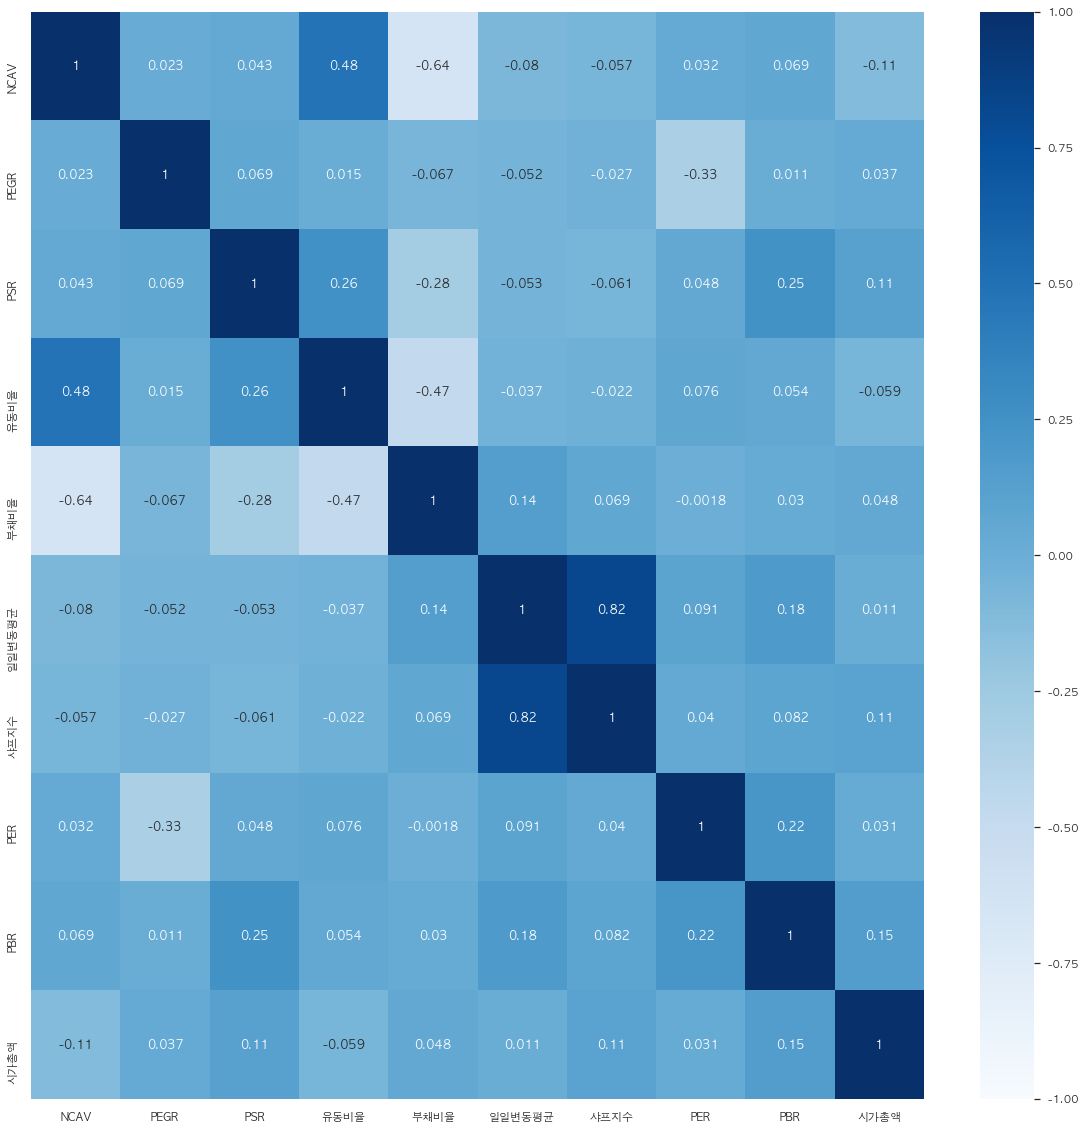

In [73]:
# 1) 독립변수 설정
df_num = df.select_dtypes(exclude='object')

# 2) 상관행렬 시각화
sns.set(font="AppleGothic",rc = {'figure.figsize':(20,20)})  
sns.heatmap(df_num.corr(), annot = True, cmap='Blues', vmin=-1, vmax=1)
plt.show()

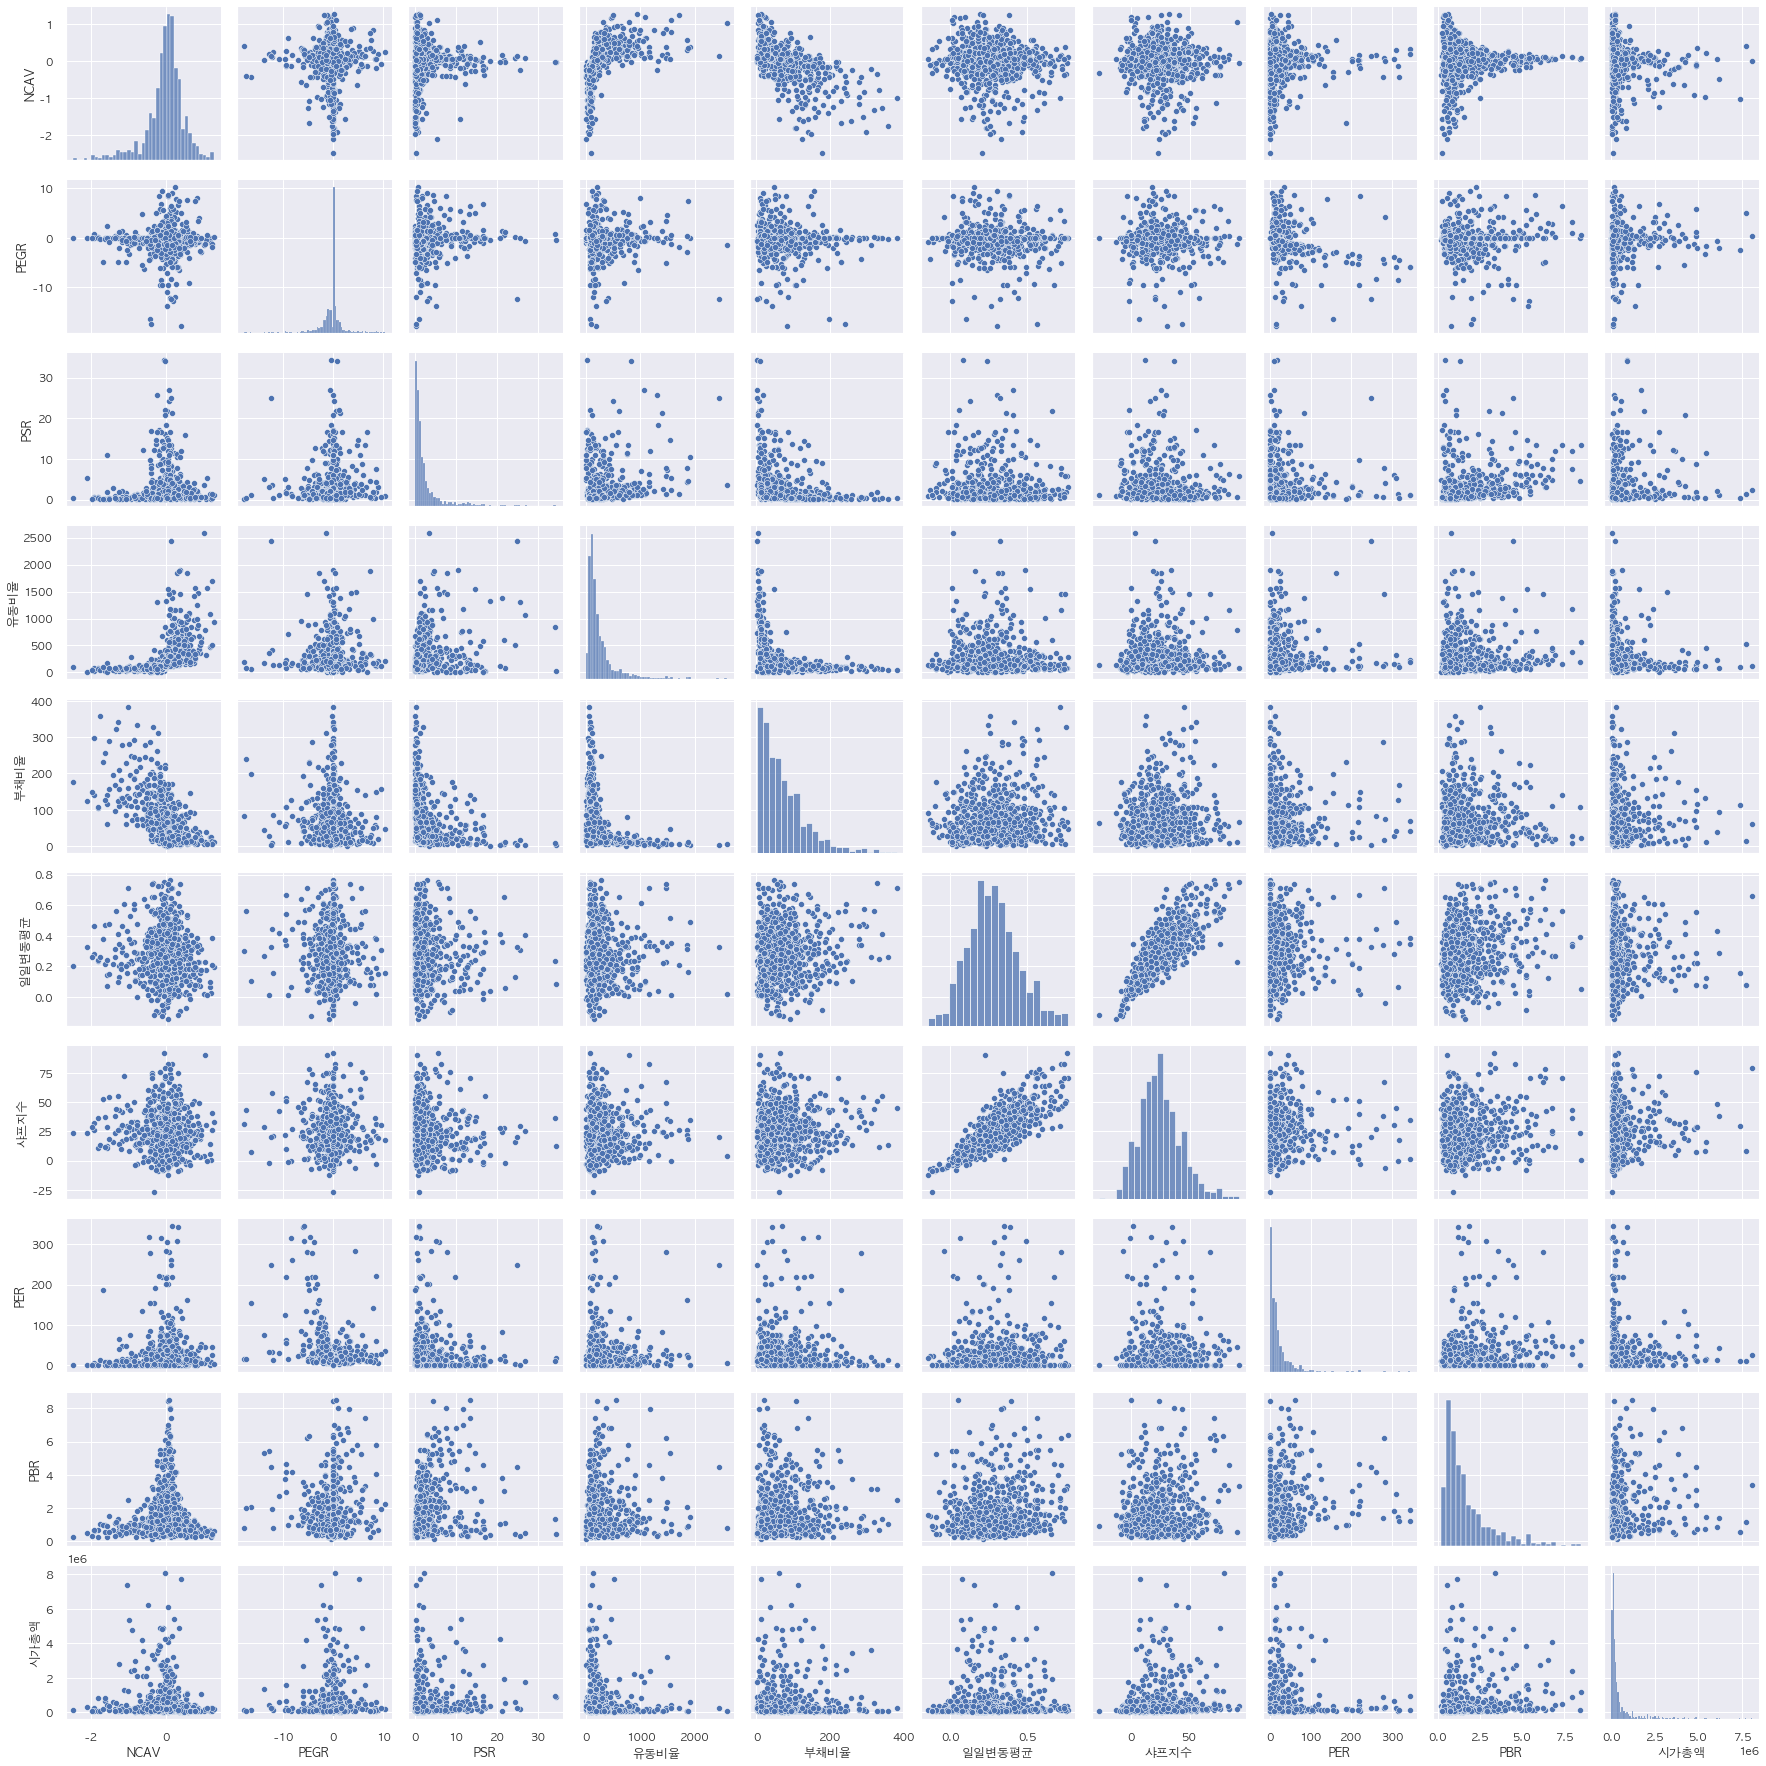

In [74]:
# 4) 변수끼리 산점도를 시각화
sns.pairplot(df_num)
plt.show()

## 1-2. 다중공선성 확인(일일변동평균이 다중공선성이 높음을 확인)

In [75]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame(
    [variance_inflation_factor(df_num.values, i) for i in range(df_num.shape[1])],
    index=df_num.columns, columns=['VIF'])
vif.sort_values(by='VIF', ascending=False)

,VIF
일일변동평균,12.252883
샤프지수,9.755016
부채비율,3.196406
PBR,2.939008
유동비율,2.203931
NCAV,1.929821
PSR,1.761524
PER,1.574957
시가총액,1.390198
PEGR,1.170589


> ### 일일변동평균과 샤프지수에서 상관관계가 존재한다 하더라도, 나중에 차원축소를 하게 된다면 상관관계가 줄어들 수 있기에 제거를 하지 않도록함
> ### 실제로, 일일변동 평균을 제거하여 PCA & clustering를 진행하였을 때 결과가 좋지 x

---
# PCA & Clustering

# 1. PCA

## 1-1. Data

In [254]:
df = pd.read_csv("./datasets/preprocessed_final.csv", index_col=0)
df["종목코드"] = df["종목코드"].astype("str")
df["종목코드"] = df["종목코드"].map(padding)
df

,종목코드,종목명,NCAV,PEGR,PSR,유동비율,부채비율,일일변동평균,샤프지수,PER,PBR,시가총액
0,000990,DB하이텍,0.028653,4.113681,2.670785,174.09,48.29,0.445142,49.648820,23.36,3.89,2499641.0
1,023150,MH에탄올,-0.301897,-0.000000,1.253321,117.69,69.27,0.081587,1.717932,0.00,1.12,64267.0
2,002360,SH에너지화학,0.361237,-0.000000,1.143522,917.82,29.79,0.166757,10.246872,0.00,1.07,104466.0
3,009160,SIMPAC,0.176695,-0.571031,0.779131,125.85,51.22,0.174309,27.341287,20.64,0.48,211992.0
4,100840,SNT에너지,0.779873,0.073893,0.577712,257.09,40.37,0.131054,21.178235,8.24,0.54,132869.0
...,...,...,...,...,...,...,...,...,...,...,...,...
878,111110,호전실업,0.630197,-0.593299,0.313680,189.04,93.35,-0.016119,-3.956150,29.34,0.71,81200.0
880,000850,화천기공,0.763649,7.384076,0.567872,341.83,24.95,0.077436,17.755082,10.23,0.26,76230.0
881,016580,환인제약,0.537149,3.277122,1.954171,798.20,11.09,0.105514,11.548340,14.69,1.22,334801.0
882,094280,효성ITX,-0.235806,1.557279,0.485197,63.82,227.69,0.222635,21.623614,22.47,4.85,233476.0


In [255]:
## PCA를 위한 데이터 구분 / 수치형 변수들로만 구성된 data로 PCA 수행
df_obj = df.select_dtypes(include='object')
df_num = df.select_dtypes(exclude='object')

# column에 PCA를 적용하기 이전에 scaling을 진행 / eigenvalue를 확인
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_ds = pd.DataFrame(scaler.fit_transform(df_num), columns=df_num.columns)
scaled_ds.head()

,NCAV,PEGR,PSR,유동비율,부채비율,일일변동평균,샤프지수,PER,PBR,시가총액
0,0.087096,1.645294,-0.037375,-0.331277,-0.364792,0.979776,1.371943,-0.063670,1.559763,2.000968
1,-0.582023,0.154056,-0.372606,-0.509369,-0.030668,-1.175034,-1.325748,-0.564884,-0.395068,-0.474766
2,0.760331,0.154056,-0.398574,2.017181,-0.659420,-0.670226,-0.845714,-0.564884,-0.430354,-0.433901
3,0.386771,-0.052947,-0.484752,-0.483603,-0.318130,-0.625465,0.116410,-0.122030,-0.846726,-0.324593
4,1.607759,0.180843,-0.532388,-0.069190,-0.490925,-0.881841,-0.230465,-0.388086,-0.804383,-0.405027


In [256]:
df_scaled = pd.concat([df[["종목코드", "종목명"]],scaled_ds], axis=1)
df_scaled

,종목코드,종목명,NCAV,PEGR,PSR,유동비율,부채비율,일일변동평균,샤프지수,PER,PBR,시가총액
0,000990,DB하이텍,0.087096,1.645294,-0.037375,-0.331277,-0.364792,0.979776,1.371943,-0.063670,1.559763,2.000968
1,023150,MH에탄올,-0.582023,0.154056,-0.372606,-0.509369,-0.030668,-1.175034,-1.325748,-0.564884,-0.395068,-0.474766
2,002360,SH에너지화학,0.760331,0.154056,-0.398574,2.017181,-0.659420,-0.670226,-0.845714,-0.564884,-0.430354,-0.433901
3,009160,SIMPAC,0.386771,-0.052947,-0.484752,-0.483603,-0.318130,-0.625465,0.116410,-0.122030,-0.846726,-0.324593
4,100840,SNT에너지,1.607759,0.180843,-0.532388,-0.069190,-0.490925,-0.881841,-0.230465,-0.388086,-0.804383,-0.405027
...,...,...,...,...,...,...,...,...,...,...,...,...
721,NaN,NaN,-0.544178,0.154056,-0.500752,-0.695799,0.484214,1.599303,2.170834,-0.564884,-0.042211,-0.338914
722,NaN,NaN,-3.053355,-0.132696,-0.614546,-0.600974,1.385298,-0.786556,-0.374383,-0.381863,-0.776154,-0.192900
723,NaN,NaN,1.310930,0.220523,-0.629524,-0.413060,1.181606,-0.164323,0.013186,-0.287028,-0.479754,-0.498537
725,NaN,NaN,1.393317,-0.292934,-0.310038,1.104550,-0.916941,0.156112,0.686544,0.419521,-0.522097,-0.462916


## 1-2. 주성분 설명력 확인

/var/folders/x3/lny9bbwx64b561c29r4y4z400000gn/T/ipykernel_53600/3091184214.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


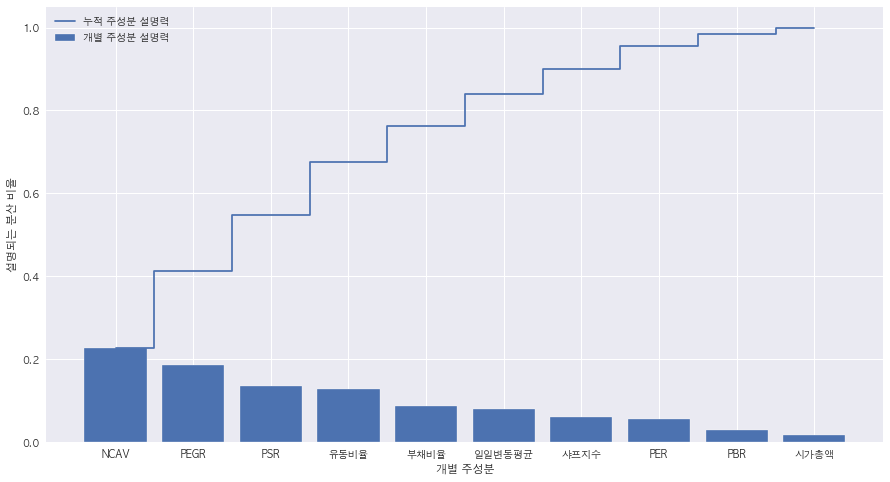

In [257]:
# PCA로 설명되는 분산을 계산 & plot
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
plt.style.use('seaborn')
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = "AppleGothic"
plt.rcParams['figure.figsize'] = [15, 8]

cov_mat = np.cov(scaled_ds.T) # 각 열에 대해 공분산 계산
eigen_vals, _ = np.linalg.eig(cov_mat) # 공분산의 고유값, 고유벡터 계산. (PCA에서의 분산 = 고유값)
tot=sum(eigen_vals) 

var_exp=[(i/tot) for i in sorted(eigen_vals,reverse=True)] # 개별 주성분 설명력(고유값 / 전체 고유값). 공분산의 고유값이 높은 순서대로 계산(%)
cum_var_exp=np.cumsum(var_exp) # 누적 주성분 설명력

plt.bar(scaled_ds.columns, var_exp, label='개별 주성분 설명력')
plt.step(scaled_ds.columns,cum_var_exp, where='mid', label='누적 주성분 설명력')
plt.ylabel('설명되는 분산 비율')
plt.xlabel('개별 주성분')
plt.legend(loc='best')

In [258]:
# 주성분별 설명력 & 누적 설명력
## 6개 이상일 때 누적설명력이 0.8을 넘음
data = {"설명력":list(eigen_vals/tot), "누적설명력": list(cum_var_exp)}
df_pca = pd.DataFrame(data, index=scaled_ds.columns)
df_pca.sort_values(by=["설명력"])
df_pca

,설명력,누적설명력
NCAV,0.226376,0.226376
PEGR,0.186227,0.412603
PSR,0.135191,0.547794
유동비율,0.128297,0.676090
부채비율,0.016161,0.762485
일일변동평균,0.027831,0.840622
샤프지수,0.086395,0.901076
PER,0.078137,0.956008
PBR,0.054931,0.983839
시가총액,0.060454,1.000000


In [259]:
# 분산 80%이상을 설명하는 주성분 갯수( = PCA 차원 수)
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(scaled_ds)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.80) + 1
d

6

## 1-3. PCA : 차원축소

In [260]:
# 분산 누적 설명량이 80% 이상 도달하는 6차원으로 축소
from sklearn.decomposition import PCA

pca = PCA(n_components=5, random_state=100)
PCA_ds = pd.DataFrame(pca.fit_transform(scaled_ds), columns=(['PC1', 'PC2', 'PC3', 'PC4', 'PC5']))
PCA_ds

,PC1,PC2,PC3,PC4,PC5
0,-0.610346,1.886578,-0.354642,-2.298667,0.817827
1,0.140350,-2.064439,0.076438,0.022112,-0.270353
2,2.038453,-0.558247,-0.661711,0.483351,0.114398
3,0.179350,-0.711171,-0.555525,0.662844,0.360627
4,1.259481,-0.795872,-0.897055,0.730369,0.424149
...,...,...,...,...,...
742,1.165178,-2.184396,0.325739,0.861617,0.147258
743,1.839146,-1.332163,-1.979250,-0.649075,-0.062976
744,2.408111,-0.653122,-0.843216,-0.269954,0.080504
745,-1.763344,-0.445362,0.933583,-0.993957,-1.587979


## 1-4. PCA 주성분들의 상관계수

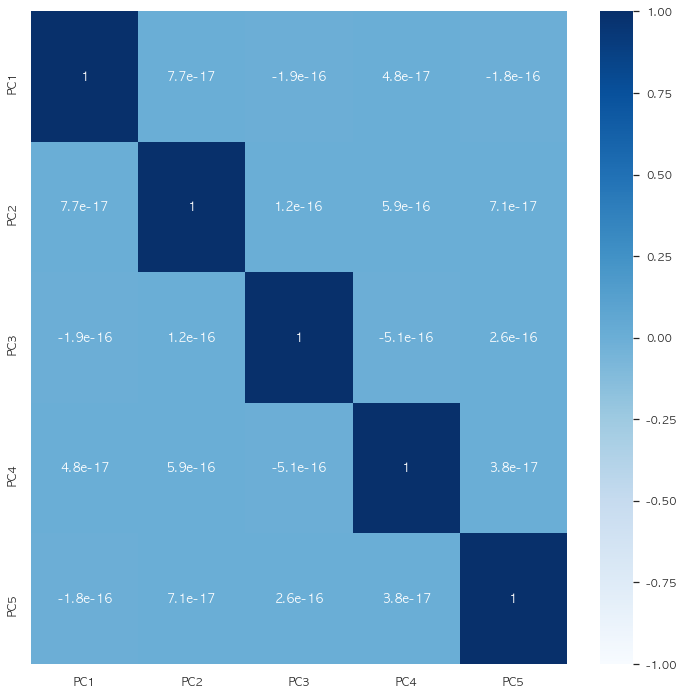

In [261]:
# 상관행렬 시각화
sns.set(font="AppleGothic",rc = {'figure.figsize':(12,12)})  
sns.heatmap(PCA_ds.corr(), annot = True, cmap='Blues', vmin=-1, vmax=1)
plt.show()

## 1-5. PCA 주성분과 변수들의 상관관계

In [262]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
# loadings.shape
loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'],
                            index=scaled_ds.columns)

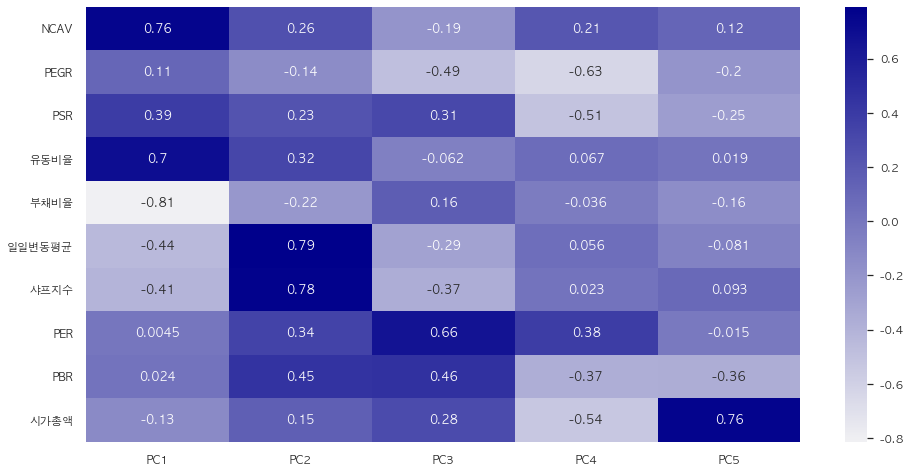

In [263]:
cmap = sns.light_palette("DarkBlue", as_cmap = True)
sns.set(font="AppleGothic",rc = {'figure.figsize':(16,8)})  
sns.heatmap(loading_matrix, annot = True, cmap = cmap)
plt.show()

[각각의 주성분들을 대표하는 변수, 절댓값 0.5이상]
- PC1 : NCAV, 유동비율, 부채비율
- PC2 : 일일변동평균, 샤프지수
- PC3 : PEGR, PER
- PC4 : PSR, PBR
- PC5 : 시가총액

---
# 2. 클러스터링

## 2-1. 클러스터 수 k 결정

### 2-1-1. Elbow Method
- 파란색 : 각 데이터들의 군집 중심과의 평균 거리
- 초록색 : 학습 시간

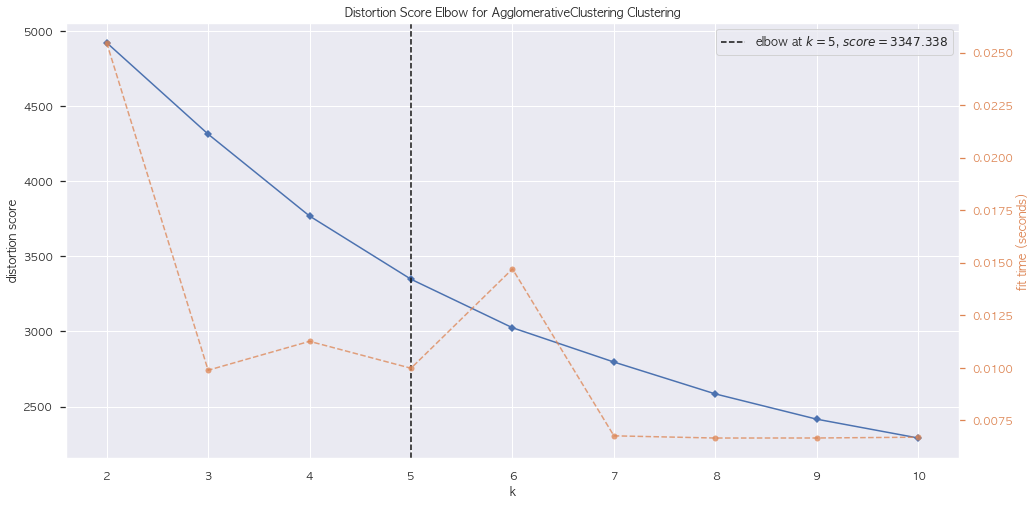

<AxesSubplot: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [264]:
# distortion score : 각 클러스터 중심으로부터 데이터간의 거리의 제곱합
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering

# Elbow_M = KElbowVisualizer(KMeans(random_state = 100), k=10, metric = 'distortion') #Kmeans
Elbow_M = KElbowVisualizer(AgglomerativeClustering(linkage='ward'), k=10, metric = 'distortion') # AgglomerativeClustering
Elbow_M.fit(PCA_ds)
Elbow_M.show()

### 2-1-2. Silhouette

In [265]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features): 

    from sklearn.cluster import AgglomerativeClustering
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = AgglomerativeClustering(n_clusters = n_cluster, linkage='ward')
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                            'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

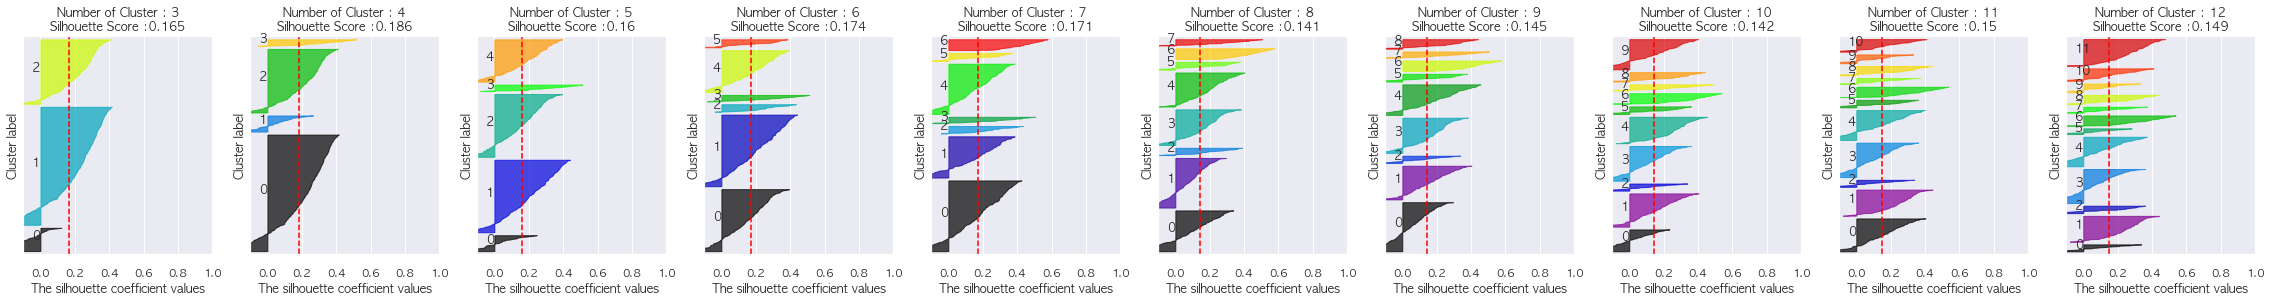

In [266]:
# cluster 개수 2개, 3개, 4개, 5개 일때의 클러스터별 실루엣 계수 평균값을 시각화
visualize_silhouette([3,4,5,6,7,8,9,10,11,12], PCA_ds)

## 2-2. Clustering

[클러스터링 알고리즘] AgglomerativeClustering  

병합 군집 알고리즘은 시작할 때 각 포인트를 하나의 클러스터로 지정하고, 그다음 어떤 종료 조건을 만족할 때까지 가장 비슷한 두 클러스터를 합쳐나감.  
(linkage 옵션에서 가장 비슷한 클러스터를 측정하는 방법을 지정함 이 측정은 항상 두 클러스터 사이에서 이뤄짐)


[linkage='ward']  

기본값인 ward 연결(linkage)은 모든 클러스터 내의 분산을 가장 작게 증가시키는 두 클러스터를 합침 그래서 크기가 비교적 비슷한 클러스터가 만들어짐.  
(ward가 대부분의 데이터셋에 알맞음 클러스터에 속한 포인트 수가 많이 다를 땐 (한 클러스터가 다른 것보다 매우 클 때) average나 complete가 더 나을 수 있음)


In [267]:
from sklearn.cluster import AgglomerativeClustering
np.random.seed(42)
AC = AgglomerativeClustering(n_clusters=11, linkage='ward')
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC

# Adding the Clusters feature to the orignal dataframe.
df["Clusters"]= yhat_AC
# df_scaled["Clusters"]= yhat_AC

## 2-3. Plot

### 2-3-1. Cluster별 Count

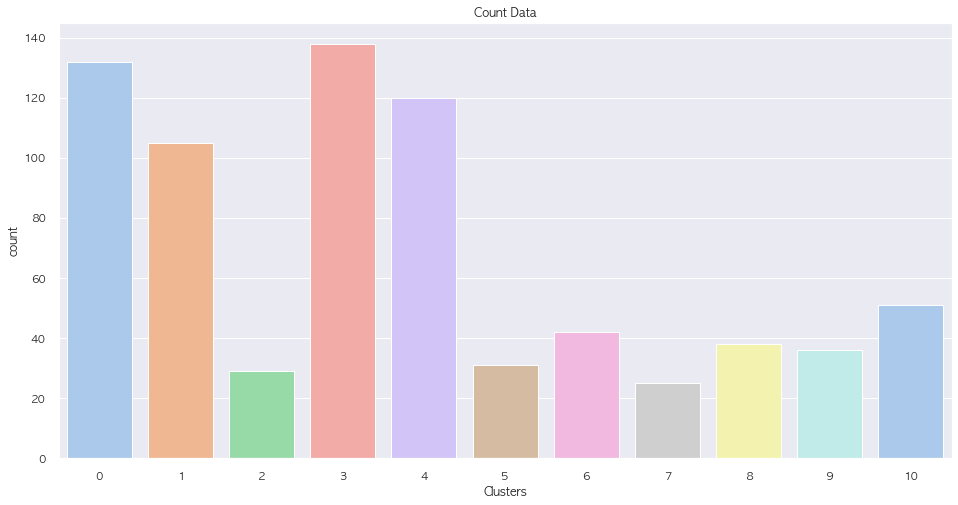

In [268]:
#Plotting countplot of clusters

pl = sns.countplot(x=df["Clusters"], palette="pastel")
pl.set_title("Count Data")
plt.show()

### 2-3-2. 2차원 plot

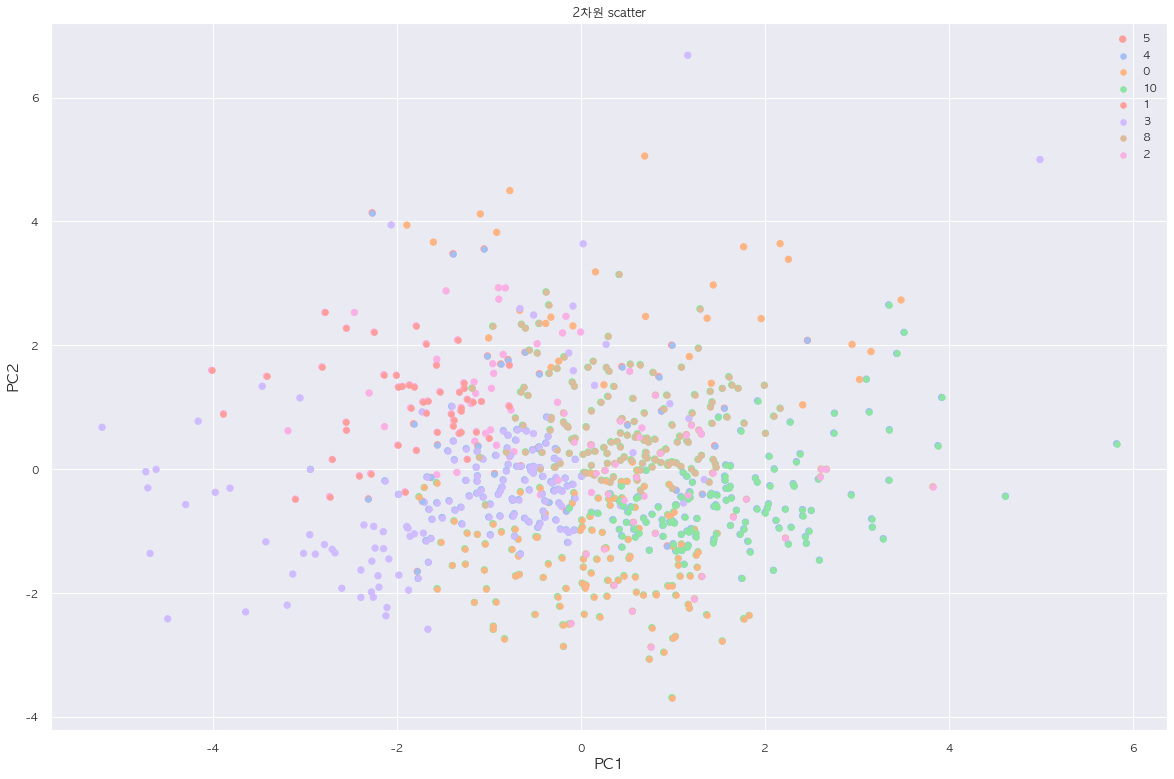

In [269]:
# Plotting the clusters / A 2D Projection Of Data In The Reduced Dimension
from matplotlib.colors import ListedColormap
from matplotlib import colors
import matplotlib.font_manager as fm
import seaborn as sns

x_col = "PC1"
y_col = "PC2"

cmap = colors.ListedColormap(["#A1C0F4", "#FFB483", "#8CE5A1", "#FF9E9B", "#CFBBFF", "#DEBB9B", "#FAB0E4"])
labels = PCA_ds["Clusters"].unique().tolist()
colors = ["#A1C0F4", "#FFB483", "#8CE5A1", "#FF9E9B", "#CFBBFF", "#DEBB9B", "#FAB0E4"]

x =PCA_ds[x_col]; y =PCA_ds[y_col]
ig = plt.figure(figsize=(20,13))
ax = plt.subplot(111)
ax.scatter(x, y, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap)
ax.set_xlabel(x_col, fontsize = 15)
ax.set_ylabel(y_col, fontsize = 15)
ax.set_title("2차원 scatter")

for label, color in zip(labels, colors):
    indicesToKeep = (PCA_ds['Clusters'] == label)
    ax.scatter(PCA_ds.loc[indicesToKeep, x_col]
            , PCA_ds.loc[indicesToKeep, y_col], c = color, s = 30)

plt.legend(labels)
plt.show()

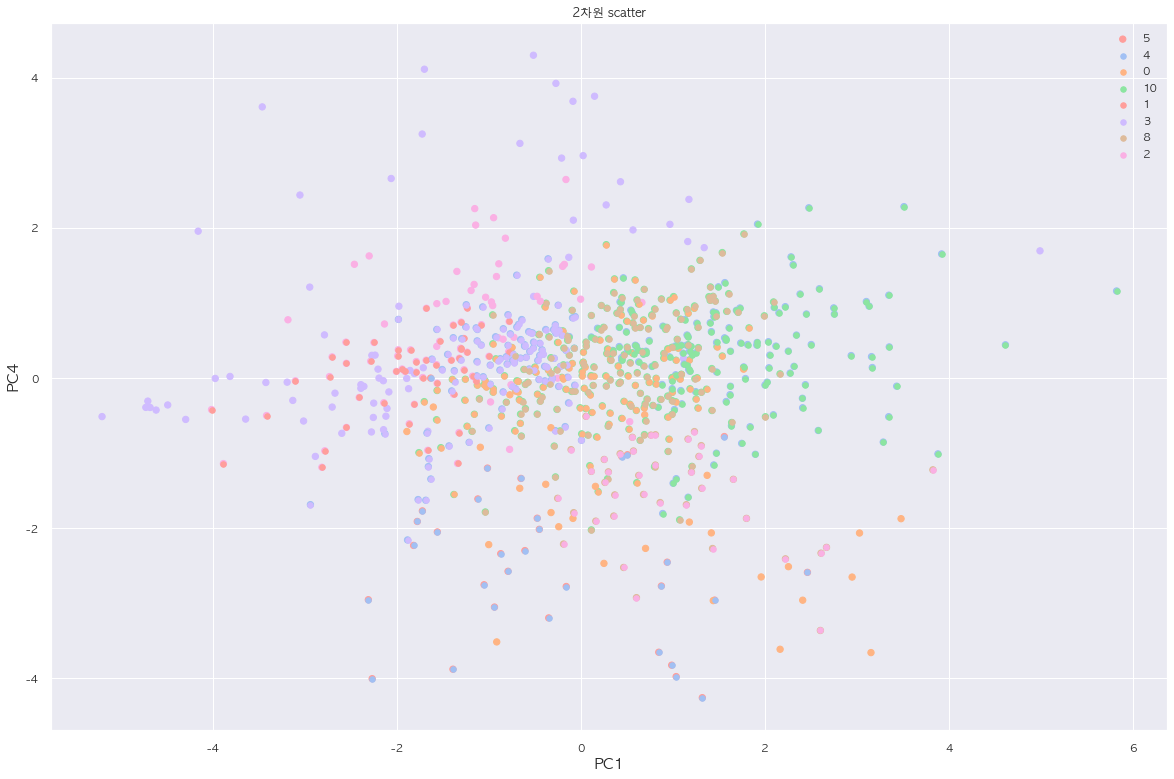

In [270]:
# Plotting the clusters / A 2D Projection Of Data In The Reduced Dimension
from matplotlib import colors
import matplotlib.font_manager as fm
import seaborn as sns

x_col = "PC1"
y_col = "PC4"

cmap = colors.ListedColormap(["#A1C0F4", "#FFB483", "#8CE5A1", "#FF9E9B", "#CFBBFF", "#DEBB9B", "#FAB0E4"])
labels = PCA_ds["Clusters"].unique().tolist()
colors = ["#A1C0F4", "#FFB483", "#8CE5A1", "#FF9E9B", "#CFBBFF", "#DEBB9B", "#FAB0E4"]

x =PCA_ds[x_col]; y =PCA_ds[y_col]
ig = plt.figure(figsize=(20,13))
ax = plt.subplot(111)
ax.scatter(x, y, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap)
ax.set_xlabel(x_col, fontsize = 15)
ax.set_ylabel(y_col, fontsize = 15)
ax.set_title("2차원 scatter")

for label, color in zip(labels, colors):
    indicesToKeep = (PCA_ds['Clusters'] == label)
    ax.scatter(PCA_ds.loc[indicesToKeep, x_col]
            , PCA_ds.loc[indicesToKeep, y_col], c = color, s = 30)

plt.legend(labels)
plt.show()

### 2-3-3. 3차원 plot

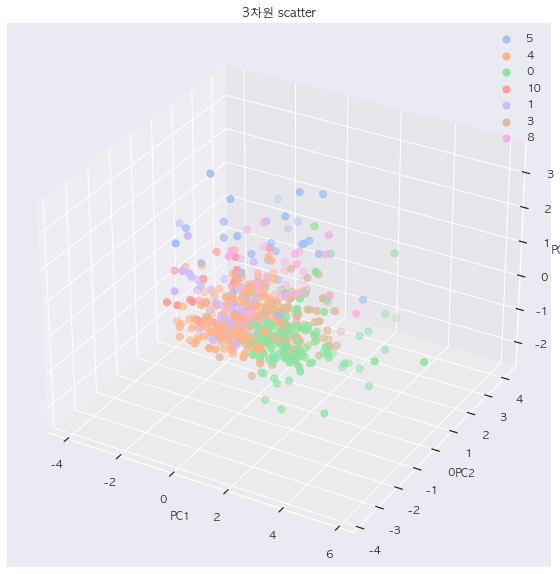

In [271]:
# Plotting the clusters / A 3D Projection Of Data In The Reduced Dimension

x_col = "PC1"
y_col = "PC2"
z_col = "PC3"

labels = PCA_ds["Clusters"].unique().tolist()
colors = ["#A1C0F4", "#FFB483", "#8CE5A1", "#FF9E9B", "#CFBBFF", "#DEBB9B", "#FAB0E4"]

x =PCA_ds[x_col]; y =PCA_ds[y_col]; z =PCA_ds[z_col]
fig = plt.figure(figsize=(50,10))
ax = plt.subplot(111, projection='3d')
ax.set_xlabel(x_col, fontsize = 10)
ax.set_ylabel(y_col, fontsize = 10)
ax.set_zlabel(z_col, fontsize = 10)
ax.set_title("3차원 scatter")

for label, color in zip(labels, colors):
    indicesToKeep = (PCA_ds['Clusters'] == label)
    ax.scatter(PCA_ds.loc[indicesToKeep, x_col]
            , PCA_ds.loc[indicesToKeep, y_col]
            , PCA_ds.loc[indicesToKeep, z_col], c = color, s = 50)

plt.legend(labels)
plt.show()

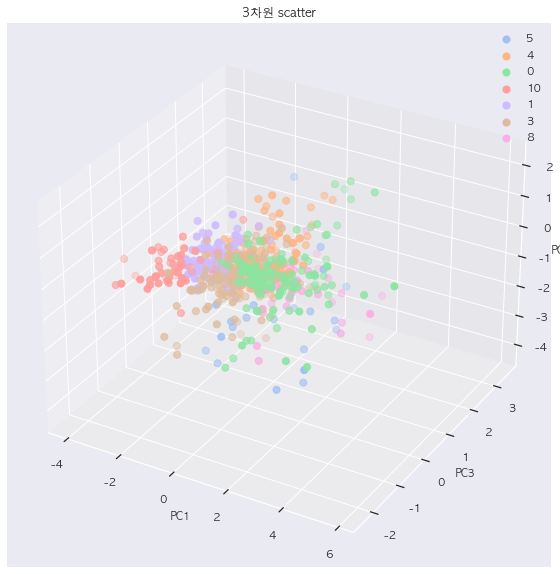

In [272]:
# Plotting the clusters / A 3D Projection Of Data In The Reduced Dimension

x_col = "PC1"
y_col = "PC3"
z_col = "PC4"

labels = PCA_ds["Clusters"].unique().tolist()
colors = ["#A1C0F4", "#FFB483", "#8CE5A1", "#FF9E9B", "#CFBBFF", "#DEBB9B", "#FAB0E4"]

x =PCA_ds[x_col]; y =PCA_ds[y_col]; z =PCA_ds[z_col]
fig = plt.figure(figsize=(50,10))
ax = plt.subplot(111, projection='3d')
ax.set_xlabel(x_col, fontsize = 10)
ax.set_ylabel(y_col, fontsize = 10)
ax.set_zlabel(z_col, fontsize = 10)
ax.set_title("3차원 scatter")

for label, color in zip(labels, colors):
    indicesToKeep = (PCA_ds['Clusters'] == label)
    ax.scatter(PCA_ds.loc[indicesToKeep, x_col]
            , PCA_ds.loc[indicesToKeep, y_col]
            , PCA_ds.loc[indicesToKeep, z_col], c = color, s = 50)

plt.legend(labels)
plt.show()

---
# 3. Cluster 특성 check!

## 3-1. Data

In [273]:
# df_plot = pd.read_csv("./datasets/preprocessed_final.csv", index_col=0)
df_plot = df.copy()
df_plot["종목코드"] = df_plot["종목코드"].astype("str")
df_plot["종목코드"] = df_plot["종목코드"].map(padding)
df_plot

,종목코드,종목명,NCAV,PEGR,PSR,유동비율,부채비율,일일변동평균,샤프지수,PER,PBR,시가총액,Clusters
0,000990,DB하이텍,0.028653,4.113681,2.670785,174.09,48.29,0.445142,49.648820,23.36,3.89,2499641.0,5
1,023150,MH에탄올,-0.301897,-0.000000,1.253321,117.69,69.27,0.081587,1.717932,0.00,1.12,64267.0,4
2,002360,SH에너지화학,0.361237,-0.000000,1.143522,917.82,29.79,0.166757,10.246872,0.00,1.07,104466.0,0
3,009160,SIMPAC,0.176695,-0.571031,0.779131,125.85,51.22,0.174309,27.341287,20.64,0.48,211992.0,0
4,100840,SNT에너지,0.779873,0.073893,0.577712,257.09,40.37,0.131054,21.178235,8.24,0.54,132869.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,111110,호전실업,0.630197,-0.593299,0.313680,189.04,93.35,-0.016119,-3.956150,29.34,0.71,81200.0,4
880,000850,화천기공,0.763649,7.384076,0.567872,341.83,24.95,0.077436,17.755082,10.23,0.26,76230.0,0
881,016580,환인제약,0.537149,3.277122,1.954171,798.20,11.09,0.105514,11.548340,14.69,1.22,334801.0,0
882,094280,효성ITX,-0.235806,1.557279,0.485197,63.82,227.69,0.222635,21.623614,22.47,4.85,233476.0,4


## 3-2. 업종 & 시장 분류

In [274]:
market_kospi = pd.read_csv("./datasets/시장분류_코스닥.csv", index_col=0)
market_kosdaq = pd.read_csv("./datasets/시장분류_코스피.csv", index_col=0)
market = pd.concat([market_kospi, market_kosdaq], axis=0)
market.columns = ["종목코드", "시장분류"]
# market

df_plot = pd.merge(df_plot, market, on=["종목코드"], how="left")
# df_plot

In [275]:
type_kospi = pd.read_csv("./datasets/업종분류_코스닥.csv", index_col=0)
type_kosdaq = pd.read_csv("./datasets/업종분류_코스피.csv", index_col=0)
type = pd.concat([type_kospi,type_kosdaq], axis=0)
type.columns = ["종목코드", "KRX업종분류"]

df_plot = pd.merge(df_plot,type, on=["종목코드"], how="left")
df_plot

,종목코드,종목명,NCAV,PEGR,PSR,유동비율,부채비율,일일변동평균,샤프지수,PER,PBR,시가총액,Clusters,시장분류,KRX업종분류
0,000990,DB하이텍,0.028653,4.113681,2.670785,174.09,48.29,0.445142,49.648820,23.36,3.89,2499641.0,5,KOSPI,전기전자
1,023150,MH에탄올,-0.301897,-0.000000,1.253321,117.69,69.27,0.081587,1.717932,0.00,1.12,64267.0,4,KOSPI,음식료품
2,002360,SH에너지화학,0.361237,-0.000000,1.143522,917.82,29.79,0.166757,10.246872,0.00,1.07,104466.0,0,KOSPI,화학
3,009160,SIMPAC,0.176695,-0.571031,0.779131,125.85,51.22,0.174309,27.341287,20.64,0.48,211992.0,0,KOSPI,기계
4,100840,SNT에너지,0.779873,0.073893,0.577712,257.09,40.37,0.131054,21.178235,8.24,0.54,132869.0,0,KOSPI,기계
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,111110,호전실업,0.630197,-0.593299,0.313680,189.04,93.35,-0.016119,-3.956150,29.34,0.71,81200.0,4,KOSPI,섬유의복
743,000850,화천기공,0.763649,7.384076,0.567872,341.83,24.95,0.077436,17.755082,10.23,0.26,76230.0,0,KOSPI,기계
744,016580,환인제약,0.537149,3.277122,1.954171,798.20,11.09,0.105514,11.548340,14.69,1.22,334801.0,0,KOSPI,의약품
745,094280,효성ITX,-0.235806,1.557279,0.485197,63.82,227.69,0.222635,21.623614,22.47,4.85,233476.0,4,KOSPI,서비스업


In [276]:
wics = pd.read_csv("./datasets/Wics_중분류.csv", index_col=0).reset_index()
df_plot = pd.merge(df_plot,wics, on=["KRX업종분류"], how="left")
df_plot.drop("KRX업종분류", inplace=True, axis=1)
df_plot.columns = ['종목코드', '종목명', 'NCAV', 'PEGR', 'PSR', '유동비율', '부채비율', '일일변동평균', '샤프지수', 'PER', 'PBR', '시가총액', 'Clusters', '시장분류', '업종분류']
df_plot

,종목코드,종목명,NCAV,PEGR,PSR,유동비율,부채비율,일일변동평균,샤프지수,PER,PBR,시가총액,Clusters,시장분류,업종분류
0,000990,DB하이텍,0.028653,4.113681,2.670785,174.09,48.29,0.445142,49.648820,23.36,3.89,2499641.0,5,KOSPI,전자와 전기제품
1,023150,MH에탄올,-0.301897,-0.000000,1.253321,117.69,69.27,0.081587,1.717932,0.00,1.12,64267.0,4,KOSPI,"식품,음료,담배"
2,002360,SH에너지화학,0.361237,-0.000000,1.143522,917.82,29.79,0.166757,10.246872,0.00,1.07,104466.0,0,KOSPI,소재
3,009160,SIMPAC,0.176695,-0.571031,0.779131,125.85,51.22,0.174309,27.341287,20.64,0.48,211992.0,0,KOSPI,자본재
4,100840,SNT에너지,0.779873,0.073893,0.577712,257.09,40.37,0.131054,21.178235,8.24,0.54,132869.0,0,KOSPI,자본재
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,111110,호전실업,0.630197,-0.593299,0.313680,189.04,93.35,-0.016119,-3.956150,29.34,0.71,81200.0,4,KOSPI,내구소비재와의류
743,000850,화천기공,0.763649,7.384076,0.567872,341.83,24.95,0.077436,17.755082,10.23,0.26,76230.0,0,KOSPI,자본재
744,016580,환인제약,0.537149,3.277122,1.954171,798.20,11.09,0.105514,11.548340,14.69,1.22,334801.0,0,KOSPI,제약과생물공학
745,094280,효성ITX,-0.235806,1.557279,0.485197,63.82,227.69,0.222635,21.623614,22.47,4.85,233476.0,4,KOSPI,상업서비스와공급품


In [277]:
df_plot["업종분류"].unique()

array(['전자와 전기제품', '식품,음료,담배', '소재', '자본재', '상업서비스와공급품', '소매(유통)',
       '제약과생물공학', '소프트웨어와서비스', '운송', '건강관리장비와서비스', '미디어와엔터테인먼트', '다각화된금융',
       '전기통신서비스', '내구소비재와의류', '반도체와반도체장비', '기술하드웨어와장비', '유틸리티', nan],
      dtype=object)

In [278]:
df_plot[df_plot["업종분류"]=="운송"]

,종목코드,종목명,NCAV,PEGR,PSR,유동비율,부채비율,일일변동평균,샤프지수,PER,PBR,시가총액,Clusters,시장분류,업종분류
18,214330,금호에이치티,0.278056,-0.000000,0.318299,173.94,46.97,0.428328,19.106421,0.00,0.92,280577.0,3,KOSPI,운송
24,212560,네오오토,-0.169853,-0.846156,0.572362,106.22,74.64,0.516305,47.139509,26.94,0.85,67252.0,10,KOSDAQ,운송
38,104040,대성파인텍,-0.020896,-2.009669,2.687488,112.52,61.33,0.613633,38.631290,70.64,1.63,86235.0,9,KOSDAQ,운송
51,004140,동방,-1.014180,-0.000000,0.405140,50.12,383.74,0.712294,45.255377,0.00,2.49,268610.0,6,KOSPI,운송
57,084670,동양고속,-0.768296,0.028340,0.828059,18.56,57.00,0.000851,-3.117870,1.97,0.52,69059.0,4,KOSPI,운송
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720,009180,한솔로지스틱스,-0.406488,-17.387629,0.273784,86.25,239.94,0.561991,43.614483,15.88,1.99,93835.0,7,KOSPI,운송
731,012450,한화에어로스페이스,-0.527298,-0.598635,1.989578,133.62,132.58,0.326291,33.901793,15.99,0.85,2070767.0,1,KOSPI,운송
734,143210,핸즈코퍼레이션,-0.287847,-0.449469,0.296589,98.60,96.22,0.086944,5.458257,20.97,0.45,146703.0,4,KOSPI,운송
737,064350,현대로템,-0.031053,-0.000000,0.646042,125.21,215.78,0.259846,21.081706,0.00,2.10,2221046.0,1,KOSPI,운송


## 3-3. 업종별 Plot

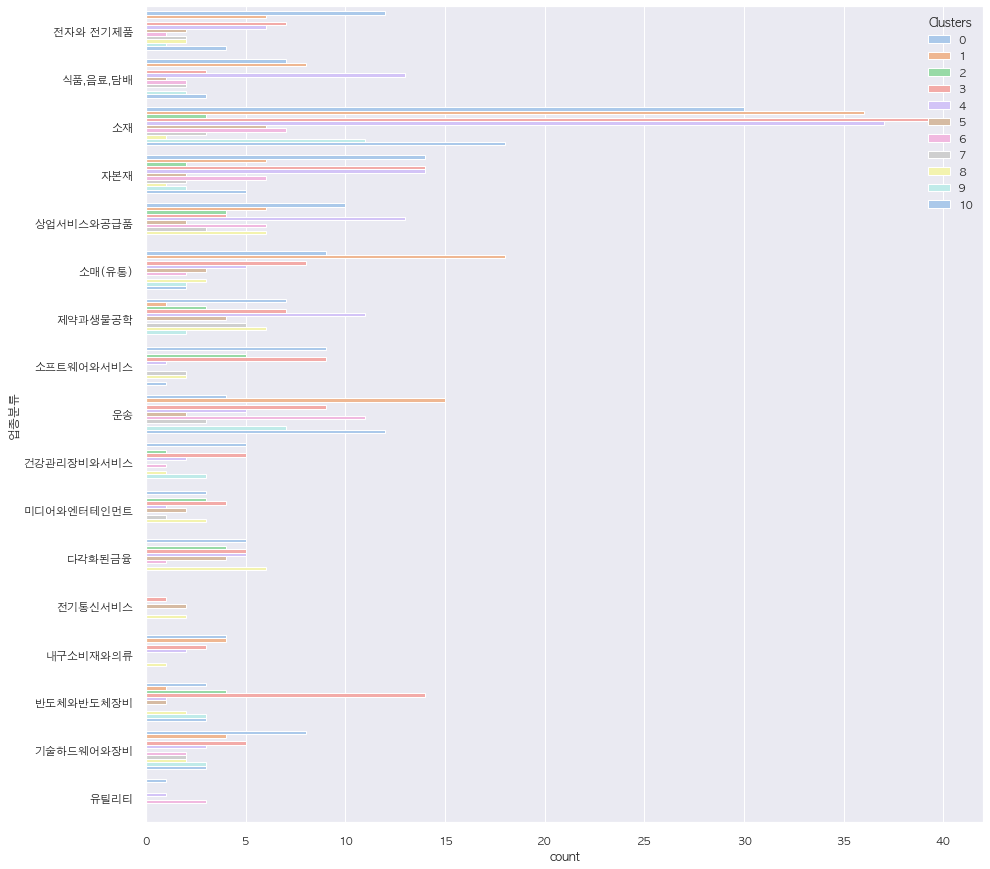

In [279]:
df_plot['Clusters'] = df_plot['Clusters'].astype('object')
# df_plot.drop(['종목코드', '종목명', '시장분류', '업종분류'], axis=1, inplace=True)

sns.set(font="AppleGothic",rc = {'figure.figsize':(15,15)}) # plt.figure(figsize=(15, 15))
sns.countplot(y = '업종분류', hue='Clusters', data=df_plot, palette="pastel")
plt.show()

## 3-4. 변수별 Plot

12it [00:04,  2.99it/s]


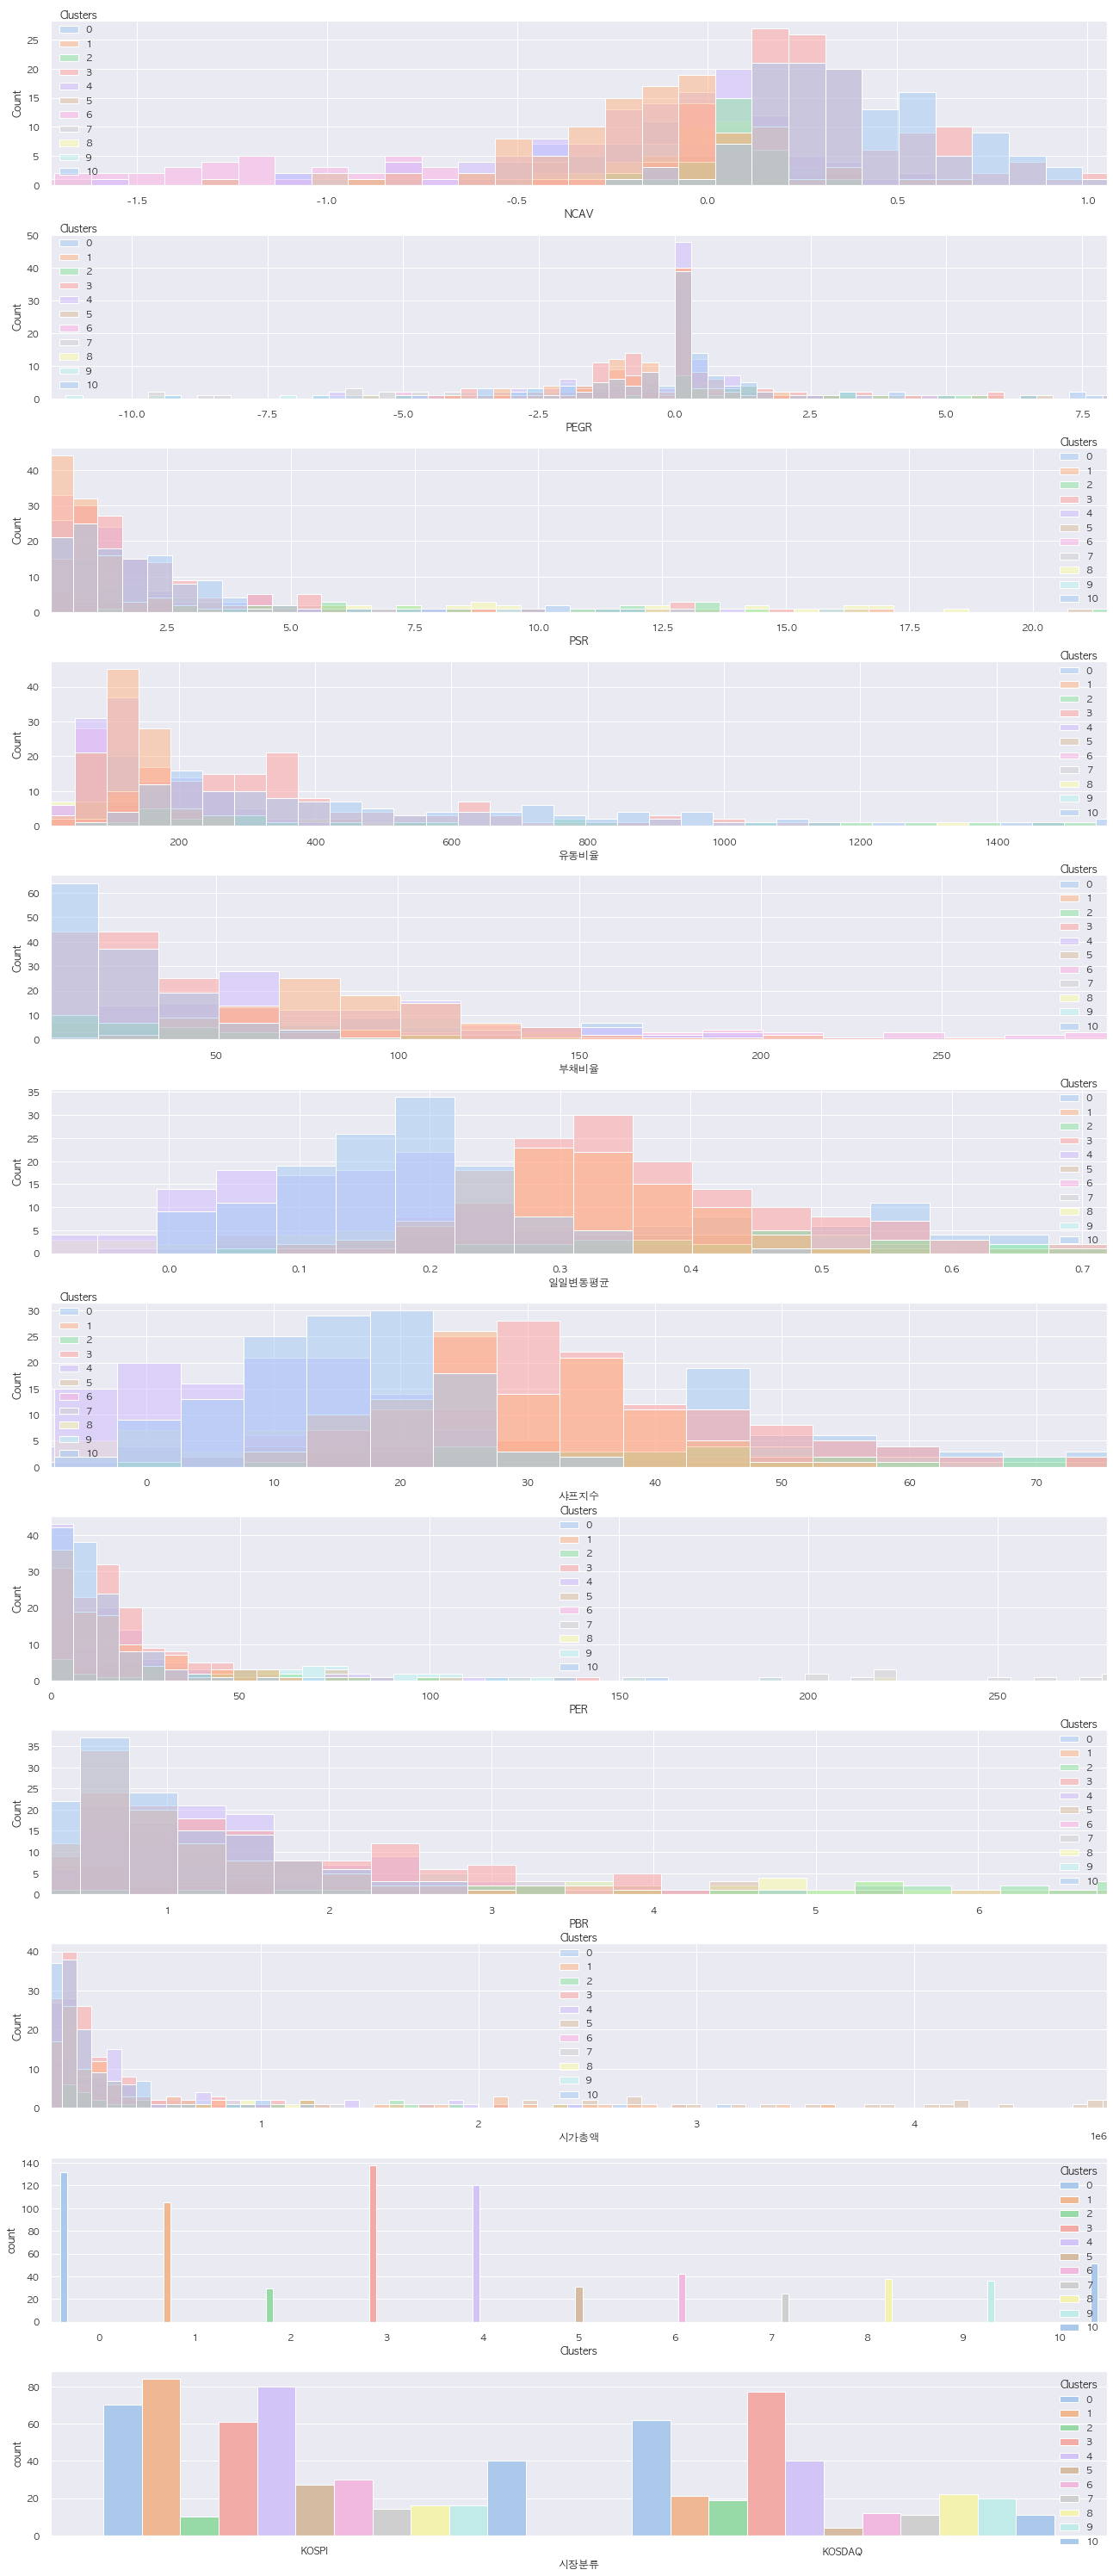

In [280]:
from tqdm import tqdm
# df_plot.drop(['종목코드', '종목명'], axis=1, inplace=True)
df_plot = df_plot[['NCAV', 'PEGR', 'PSR', '유동비율', '부채비율', '일일변동평균', '샤프지수', 'PER', 'PBR', '시가총액', 'Clusters', '시장분류', '업종분류']]


fig = plt.figure(figsize=(22, 72))
for i, col in tqdm(enumerate(df_plot.columns.tolist()[:-1])):
    plt.subplot(16, 1, i+1)
    plt.subplots_adjust(hspace=0.3)
    
    if df_plot[col].dtype == 'float':
        plt.xlim((df[col].quantile(0.01), df[col].quantile(0.99)))
        sns.histplot(x = df_plot[col], hue='Clusters', data=df_plot, palette="pastel")
    else:
        sns.countplot(x = df_plot[col], hue='Clusters', data=df_plot, palette="pastel")

## 3-5. Cluster 특성

Text(0.5, 1.0, '클러스터별 시가총액 중간값')

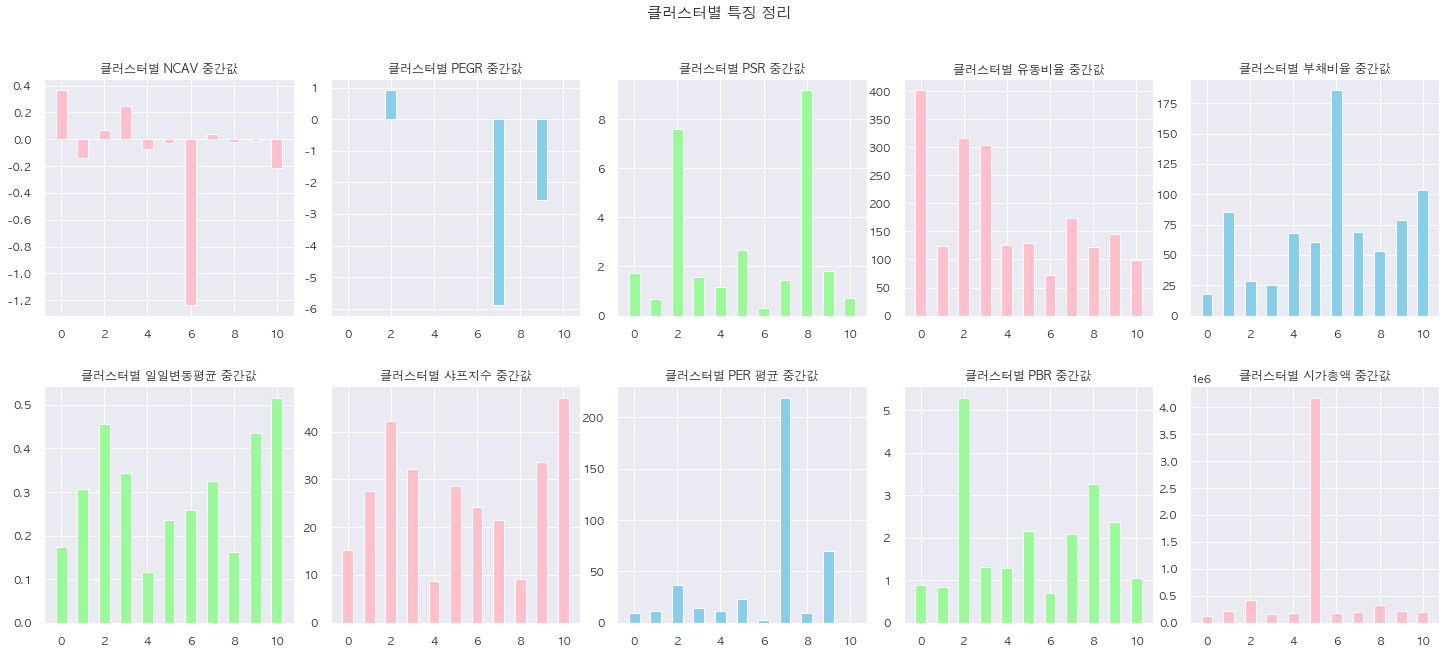

In [281]:
# 클러스터별 재무정보의 차이가 잆는지 확인합니다.

f, axes = plt.subplots(2, 5)
f.set_size_inches((25, 10))
plt.subplots_adjust(wspace = 0.15, hspace = 0.3)

# figure 전체 제목
f.suptitle('클러스터별 특징 정리', fontsize = 15)


# 1.펀더멘탈 지표
## NCAV
axes[0, 0].bar(df.groupby('Clusters')['NCAV'].mean().index, df.groupby('Clusters')['NCAV'].median().values,
    width = 0.5, color = 'pink')
axes[0, 0].set_title('클러스터별 NCAV 중간값', fontsize = 12)

## PEGR
axes[0, 1].bar(df.groupby('Clusters')['PEGR'].mean().index, df.groupby('Clusters')['PEGR'].median().values,
    width = 0.5, color = 'skyblue')
axes[0, 1].set_title('클러스터별 PEGR 중간값', fontsize = 12)

## PSR
axes[0, 2].bar(df.groupby('Clusters')['PSR'].mean().index, df.groupby('Clusters')['PSR'].median().values,
    width = 0.5, color = 'palegreen')
axes[0, 2].set_title('클러스터별 PSR 중간값', fontsize = 12)

## 유동비율
axes[0, 3].bar(df.groupby('Clusters')['유동비율'].mean().index, df.groupby('Clusters')['유동비율'].median().values,
    width = 0.5, color = 'pink')
axes[0, 3].set_title('클러스터별 유동비율 중간값', fontsize = 12)

## 부채비율
axes[0, 4].bar(df.groupby('Clusters')['부채비율'].mean().index, df.groupby('Clusters')['부채비율'].median().values,
    width = 0.5, color = 'skyblue')
axes[0, 4].set_title('클러스터별 부채비율 중간값', fontsize = 12)


# 2. 위험대비성과지표
## 일일변동평균
axes[1, 0].bar(df.groupby('Clusters')['일일변동평균'].mean().index, df.groupby('Clusters')['일일변동평균'].median().values,
    width = 0.5, color = 'palegreen')
axes[1, 0].set_title('클러스터별 일일변동평균 중간값', fontsize = 12)

## 샤프지수
axes[1, 1].bar(df.groupby('Clusters')['샤프지수'].mean().index, df.groupby('Clusters')['샤프지수'].median().values,
    width = 0.5, color = 'pink')
axes[1, 1].set_title('클러스터별 샤프지수 중간값', fontsize = 12)


# 3. 팩터지표
## PER
axes[1, 2].bar(df.groupby('Clusters')['PER'].mean().index, df.groupby('Clusters')['PER'].median().values,
    width = 0.5, color = 'skyblue')
axes[1, 2].set_title('클러스터별 PER 평균 중간값', fontsize = 12)

## PBR
axes[1, 3].bar(df.groupby('Clusters')['PBR'].mean().index, df.groupby('Clusters')['PBR'].median().values,
    width = 0.5, color = 'palegreen')
axes[1, 3].set_title('클러스터별 PBR 중간값', fontsize = 12)

# 시가총액
axes[1, 4].bar(df.groupby('Clusters')['시가총액'].mean().index, df.groupby('Clusters')['시가총액'].median().values,
    width = 0.5, color = 'pink')
axes[1, 4].set_title('클러스터별 시가총액 중간값', fontsize = 12)


- 높으면 좋은 것 : NCAV, 유동비율 / 일일변동평균, 샤프지수 평균 / 시가총액
- 낮으면 좋은 것 : PEGR, PSR, 부채비율 / PER, PBR

[제외]
- 1(유동비율, 부채비율), 2(PSR) / 4(애매) / 6(NCAV) / 7(PER) / 8(PSR) / 9(부채비율, PER)
- 5(대형주)
------
[특성]
- 0(NCAV,유동비율) / 3(유동비율, 샤프지수) / 10(KOSPI+변동성,PER)

## 3-6. 기업선정(cluster는 3으로만!)

### 3-6-1. 클러스터별 수익률 확인

In [618]:
# 수익률
df_earnings20 = pd.read_csv("./datasets/(수익률)20.04.01_21.03.31.csv", index_col=0)
df_earnings20.columns = ['종목코드', '2020수익률']
df_earnings21 = pd.read_csv("./datasets/(수익률)21.04.01_22.03.31.csv", index_col=0)
df_earnings21.columns = ['종목코드', '2021수익률']

cluster3 = df[df["Clusters"]==3]
cluster3 = pd.merge(cluster3, df_earnings20, on="종목코드", how="left")
cluster3 = pd.merge(cluster3, df_earnings21, on="종목코드", how="left")
cluster3.sort_values(by="2020수익률", ascending=False).head(10)

# cluster3,10 생략

,종목코드,종목명,NCAV,PEGR,PSR,유동비율,부채비율,일일변동평균,샤프지수,PER,PBR,시가총액,Clusters,2020수익률,2021수익률
70,011500,한농화성,0.128839,5.544042,1.193869,266.54,30.97,0.710330,55.335727,24.39,2.07,248629.0,3,311.917098,0.000000
11,100130,동국S&C,0.314028,-2.470764,2.402970,369.09,19.83,0.681727,59.380833,39.65,1.48,387430.0,3,300.000000,-10.015175
83,006650,대한유화,0.210659,-0.702846,1.133549,1009.29,8.51,0.615871,63.678211,18.90,1.19,2115750.0,3,262.068966,-47.981366
32,004440,삼일씨엔에스,0.354530,-1.362504,1.159808,322.17,17.68,0.597179,64.158023,80.33,0.77,215807.0,3,251.659751,-26.993865
84,084010,대한제강,0.308005,-1.420152,0.534076,178.33,41.92,0.548192,75.166933,12.46,0.89,411600.0,3,248.279458,27.863777
2,121440,골프존뉴딘홀딩스,-0.168996,-0.000000,5.313521,372.85,20.05,0.522380,75.985830,0.00,0.68,305427.0,3,227.064220,17.622378
16,147760,마이크로프랜드,0.155743,-0.000000,1.823619,234.38,38.39,0.558692,55.453842,0.00,2.26,93051.0,3,217.929760,-26.451613
106,004490,세방전지,0.555391,1.782101,1.012612,373.50,21.40,0.537845,45.788965,13.66,1.03,1090600.0,3,203.112840,-15.555556
101,024950,삼천리자전거,0.245013,-0.000000,1.676034,265.68,36.96,0.519387,48.813004,0.00,2.20,175211.0,3,202.752294,0.000000
94,210540,디와이파워,0.268949,0.423695,1.210162,346.64,25.40,0.536747,55.852371,10.90,1.25,208136.0,3,202.083333,-18.528610


### 3-6-2. 컬럼별 rank 파생변수 생성(+높을수록 좋은 컬럼 역수화)

In [619]:
# 높으면 좋은 컬럼 역수화
reciprocal_list=["NCAV", "유동비율", "일일변동평균", "샤프지수", "시가총액"]
for i in reciprocal_list:
    cluster3[i] = cluster3[i].map(reciprocal)
    
column_list = ["NCAV", "PEGR", "PSR", "유동비율", "부채비율", "일일변동평균", "샤프지수", "PER", "PBR", "시가총액"]
for i in column_list:
    cluster3[i] = cluster3[i].rank(method='min')

cluster3["rank_일일변동+샤프지수"] = cluster3["일일변동평균"]+cluster3["샤프지수"]
cluster3.sort_values(by="rank_일일변동+샤프지수", ascending=True).head(10)

# cluster3,10 생략

,종목코드,종목명,NCAV,PEGR,PSR,유동비율,부채비율,일일변동평균,샤프지수,PER,PBR,시가총액,Clusters,2020수익률,2021수익률,rank_일일변동+샤프지수
83,006650,대한유화,99.0,48.0,49.0,4.0,5.0,3.0,5.0,91.0,62.0,1.0,3,262.068966,-47.981366,8.0
32,004440,삼일씨엔에스,61.0,23.0,52.0,67.0,45.0,4.0,4.0,136.0,34.0,46.0,3,251.659751,-26.993865,8.0
11,100130,동국S&C,72.0,10.0,94.0,47.0,52.0,2.0,9.0,127.0,78.0,21.0,3,300.000000,-10.015175,11.0
84,084010,대한제강,73.0,20.0,11.0,110.0,106.0,10.0,3.0,56.0,41.0,18.0,3,248.279458,27.863777,13.0
70,011500,한농화성,122.0,132.0,53.0,83.0,83.0,1.0,13.0,107.0,100.0,37.0,3,311.917098,0.000000,14.0
2,121440,골프존뉴딘홀딩스,14.0,59.0,125.0,46.0,54.0,14.0,2.0,1.0,25.0,29.0,3,227.064220,17.622378,16.0
16,147760,마이크로프랜드,114.0,59.0,84.0,94.0,97.0,7.0,12.0,1.0,104.0,107.0,3,217.929760,-26.451613,19.0
94,210540,디와이파워,79.0,101.0,56.0,58.0,70.0,13.0,11.0,50.0,65.0,50.0,3,202.083333,-18.528610,24.0
47,108320,실리콘웍스,64.0,4.0,41.0,74.0,103.0,27.0,6.0,118.0,118.0,3.0,3,180.519481,91.688654,33.0
48,108320,실리콘웍스,64.0,4.0,41.0,74.0,103.0,27.0,6.0,118.0,118.0,3.0,3,180.519481,91.688654,33.0


### 3-6-3. final_rank 계산하는 최적의 2개 컬럼 찾기
1. 수치가 높을수록 좋은 컬럼의 값들을 역수화한다.
1. 각각의 컬럼에 rank를 매긴다.
2. 컬럼 2개의 조합에 따라 rank를 합산하고 rank가 좋은 순서대로 상위 10개의 기업들의 2020년 수익률의 평균을 구한다.
3. (컬럼조합에 따른 상위 10개 기업의)2020년 수익률 평균을 기준으로 내림차순하여 최적의 컬럼을 확인

In [620]:
def func_ms2(df_origin, n_cluster):

    df_cluster = df_origin[df_origin["Clusters"]==n_cluster]
    df_cluster = pd.merge(df_cluster, df_earnings20, on="종목코드", how="left")
    df_cluster = pd.merge(df_cluster, df_earnings21, on="종목코드", how="left")

    # 높으면 좋은 컬럼 역수화
    reciprocal_list=["NCAV", "유동비율", "일일변동평균", "샤프지수", "시가총액"]
    for i in reciprocal_list:
        df_cluster[i] = df_cluster[i].map(reciprocal)

    # 조합할 columns 정의
    column_list = ["NCAV", "PEGR", "PSR", "유동비율", "부채비율", "일일변동평균", "샤프지수", "PER", "PBR", "시가총액"]
    for i in column_list:
        df_cluster[i] = df_cluster[i].rank(method='min')

    # 수익률 계산
    def rank_earning(df_cluster, col1, col2):
        df_cluster["rank_Total"] = df_cluster[col1]+df_cluster[col2]
        earning20 = df_cluster.sort_values(by="rank_Total", ascending=True).head(10)["2020수익률"]
        earning20 = sum(earning20)/10
        earning21 = df_cluster.sort_values(by="rank_Total", ascending=True).head(10)["2021수익률"]
        earning21 = sum(earning21)/10
        
        dataframe = pd.DataFrame({"2021수익률":[earning21], "2020수익률":[earning20], "col1":col1, "col2":col2})
        return dataframe

    dfs = list()
    
    for i in range(len(column_list)):
        for j in range(len(column_list)):
            if j <= i:
                continue
            df_insert = rank_earning(df_cluster, column_list[i], column_list[j])
            dfs.append(df_insert)

    df_result = pd.concat(dfs)
    return df_result.sort_values(by = '2020수익률', ascending = False)
    
    

In [621]:
func_ms2(df, 0).head(10)

,2021수익률,2020수익률,col1,col2
0,-7.611508,131.389339,일일변동평균,PER
0,23.624125,90.292213,일일변동평균,샤프지수
0,17.053292,88.960248,유동비율,일일변동평균
0,24.202182,85.455609,부채비율,일일변동평균
0,3.239524,79.555233,PEGR,일일변동평균
0,-1.315044,74.276085,NCAV,일일변동평균
0,7.425249,70.367499,유동비율,샤프지수
0,-14.014956,70.168210,일일변동평균,시가총액
0,16.422841,69.432713,부채비율,샤프지수
0,0.714917,67.049484,유동비율,부채비율


In [622]:
func_ms2(df, 3).head(10)

,2021수익률,2020수익률,col1,col2
0,9.889283,238.204155,일일변동평균,샤프지수
0,18.174502,208.045818,일일변동평균,시가총액
0,22.227919,204.164464,샤프지수,시가총액
0,8.945762,195.818571,부채비율,일일변동평균
0,30.856965,194.110415,PEGR,샤프지수
0,-0.154470,192.451025,일일변동평균,PER
0,13.204873,189.959174,일일변동평균,PBR
0,13.649180,189.677773,PEGR,일일변동평균
0,-18.117114,187.048863,PSR,일일변동평균
0,16.866842,186.032596,샤프지수,PER


In [623]:
func_ms2(df, 10).head(10)

,2021수익률,2020수익률,col1,col2
0,0.618271,285.532453,일일변동평균,PER
0,13.292209,278.777847,PEGR,일일변동평균
0,14.841033,265.207682,일일변동평균,샤프지수
0,17.064010,264.026004,부채비율,일일변동평균
0,2.572145,259.543554,NCAV,일일변동평균
0,3.460768,257.913678,일일변동평균,시가총액
0,8.999192,256.211177,샤프지수,PER
0,29.530334,247.179925,PSR,일일변동평균
0,10.429160,239.941158,NCAV,샤프지수
0,-6.688234,238.806445,부채비율,PER


### 3-6-4. 2020년 수익률에 가장 높은 영향을 미치는 **column 3개로** 각 컬럼에 rank를 주어 가장 높은 수익률 계산

In [624]:
def func_ms3(df_origin, n_cluster):

    df_cluster = df_origin[df_origin["Clusters"]==n_cluster]
    df_cluster = pd.merge(df_cluster, df_earnings20, on="종목코드", how="left")
    df_cluster = pd.merge(df_cluster, df_earnings21, on="종목코드", how="left")

    # 높으면 좋은 컬럼 역수화
    reciprocal_list=["NCAV", "유동비율", "일일변동평균", "샤프지수", "시가총액"]
    for i in reciprocal_list:
        df_cluster[i] = df_cluster[i].map(reciprocal)

    # 조합할 columns 정의
    column_list = ["NCAV", "PEGR", "PSR", "유동비율", "부채비율", "일일변동평균", "샤프지수", "PER", "PBR", "시가총액"]
    for i in column_list:
        df_cluster[i] = df_cluster[i].rank(method='min')

    # 수익률 계산
    def rank_earning(df_cluster, col1, col2, col3):
        df_cluster["rank_Total"] = df_cluster[col1]+df_cluster[col2]+df_cluster[col3]
        earning20 = df_cluster.sort_values(by="rank_Total", ascending=True).head(10)["2020수익률"]
        earning20 = sum(earning20)/10
        earning21 = df_cluster.sort_values(by="rank_Total", ascending=True).head(10)["2021수익률"]
        earning21 = sum(earning21)/10
        
        dataframe = pd.DataFrame({"2021수익률":[earning21], "2020수익률":[earning20], "col1":col1, "col2":col2, "col3":col3})
        return dataframe

    dfs = list()
    for i in range(len(column_list)):
        for j in range(len(column_list)):
            if j <= i:
                continue
            for k in range(len(column_list)):
                if k <= j:
                    continue
                df_insert = rank_earning(df_cluster, column_list[i], column_list[j], column_list[k])
                dfs.append(df_insert)

    df_result = pd.concat(dfs)
    return df_result.sort_values(by = '2020수익률', ascending = False)

In [625]:
func_ms3(df, 0).head(10)

,2021수익률,2020수익률,col1,col2,col3
0,-6.559823,132.710588,PEGR,일일변동평균,PER
0,-13.721589,122.697506,일일변동평균,PER,시가총액
0,11.188897,88.980950,유동비율,일일변동평균,샤프지수
0,24.721923,86.815373,부채비율,일일변동평균,샤프지수
0,11.052177,86.796244,NCAV,일일변동평균,샤프지수
0,9.173348,86.327525,유동비율,부채비율,일일변동평균
0,7.366369,84.908002,PSR,부채비율,일일변동평균
0,0.449628,82.238534,NCAV,유동비율,일일변동평균
0,2.051586,82.061407,PEGR,일일변동평균,샤프지수
0,2.861355,81.925521,PEGR,유동비율,일일변동평균


In [626]:
func_ms3(df, 3).head(10)

,2021수익률,2020수익률,col1,col2,col3
0,11.128239,235.296565,일일변동평균,샤프지수,시가총액
0,12.387471,219.509449,PEGR,일일변동평균,샤프지수
0,-6.809638,218.663597,유동비율,일일변동평균,샤프지수
0,12.184782,213.573832,일일변동평균,샤프지수,PBR
0,12.999396,208.048443,부채비율,일일변동평균,샤프지수
0,-2.318953,206.741101,일일변동평균,PBR,시가총액
0,15.555186,204.083455,PEGR,일일변동평균,시가총액
0,-11.884079,202.901116,부채비율,일일변동평균,시가총액
0,34.637138,202.002969,NCAV,일일변동평균,샤프지수
0,4.186300,197.132680,PSR,일일변동평균,샤프지수


In [627]:
func_ms3(df, 10).head(10)

,2021수익률,2020수익률,col1,col2,col3
0,0.618271,285.532453,PEGR,일일변동평균,PER
0,11.375965,278.449213,유동비율,일일변동평균,샤프지수
0,5.301801,273.437763,NCAV,일일변동평균,샤프지수
0,2.315508,272.351599,일일변동평균,샤프지수,PBR
0,12.481811,268.785342,일일변동평균,샤프지수,PER
0,3.602355,267.907964,PEGR,부채비율,일일변동평균
0,-8.248173,266.976808,부채비율,샤프지수,PER
0,-2.938343,266.147780,부채비율,일일변동평균,PER
0,3.495912,265.473891,일일변동평균,PER,PBR
0,14.841033,265.207682,PEGR,일일변동평균,샤프지수


### 3-6-5. 지지도(support) count : 수익률에 영향을 많이 미치는 컬럼3개 조합 중 빈도 많은 컬럼 2개 count

In [628]:
column_list = ["NCAV", "PEGR", "PSR", "유동비율", "부채비율", "일일변동평균", "샤프지수", "PER", "PBR", "시가총액"]
dfs = list()
comb2 = list()

for i in range(len(column_list)):
    for j in range(len(column_list)):
        if j <= i:
            continue
        comb2.append([column_list[i],column_list[j]])
# comb2[0]


df_3col = func_ms3(df, 0).head(10)
df_3col = df_3col[["col1","col2","col3"]]
df_3col.reset_index(drop=True, inplace=True)

dfs = list()
for i in comb2: # 'PER', 'PBR', '시가총액']
    counts=0
        
    for k in range(len(df_3col)): # K:0~9
        cnt=0
        for j in i: # "PER"
            if j not in list(df_3col.iloc[k]):
                continue
            cnt += 1
            if cnt == 2:
                counts += 1
                
    dataframe = pd.DataFrame({"counts":[counts], "columns":str(i)})
    dfs.append(dataframe)
                
df_result = pd.concat(dfs)
# df_result
df_result.sort_values(by="counts", ascending=False).head(10)

,counts,columns
0,4,"['유동비율', '일일변동평균']"
0,4,"['일일변동평균', '샤프지수']"
0,3,"['부채비율', '일일변동평균']"
0,3,"['PEGR', '일일변동평균']"
0,2,"['NCAV', '일일변동평균']"
0,2,"['일일변동평균', 'PER']"
0,1,"['유동비율', '샤프지수']"
0,1,"['유동비율', '부채비율']"
0,1,"['부채비율', '샤프지수']"
0,1,"['PSR', '일일변동평균']"


> ### 확인해본 결과 "유동비율-일일변동평균", "일일변동평균-샤프지수" 조합이 빈도가 가장 많았다.  
> ### 그러나 컬럼 2개로 rank합산을 하여 2020수익률 평균을 계산해 봤을 때 cluster0,3,10 모두에서 "일일변동평균-샤프지수"이 상위를 차지하기 때문에  
> ### "일일변동평균-샤프지수" 조합으로 rank를 합산하여 상위 10개 기업을 대상으로 투자를 진행한다.

## 3-7. 투자대상 기업

### 3-7-1. cluster3 / 일일변동평균-샤프지수 조합에서의 10개 기업

In [629]:
func_ms2(df,3).head(1)

,2021수익률,2020수익률,col1,col2
0,9.889283,238.204155,일일변동평균,샤프지수


In [716]:
cluster0 = df[df["Clusters"]==3]

df_earnings21 = pd.read_csv("./datasets/(수익률)21.04.01_22.03.31.csv", index_col=0)
df_earnings21.columns = ['종목코드', '2021수익률']
cluster0 = pd.merge(cluster0, df_earnings21, on="종목코드", how="left")

# 높으면 좋은 컬럼 역수화
reciprocal_list=["NCAV", "유동비율", "일일변동평균", "샤프지수", "시가총액"]
for i in reciprocal_list:
    cluster0[i] = cluster0[i].map(reciprocal)
    
# rank
column_list = ["NCAV", "PEGR", "PSR", "유동비율", "부채비율", "일일변동평균", "샤프지수", "PER", "PBR", "시가총액"]
for i in column_list:
    cluster0[i] = cluster0[i].rank(method='min')

# 일일변동-샤프지수 조합으로 rank합산하여 2020수익률 기준 상위 10개 기업 확인
cluster0["rank_일일변동+샤프지수"] = cluster0["일일변동평균"]+cluster0["샤프지수"]
final_company = cluster0.sort_values(by="rank_일일변동+샤프지수", ascending=True).head(11)
final_company = final_company.drop(index=48)
final_company.reset_index(inplace=True, drop=True)
print(final_company.shape)
print(sum(final_company["2021수익률"])/10)
print(list(final_company["종목코드"]))
final_company

(10, 15)
-0.9830930722016984
['006650', '004440', '100130', '084010', '011500', '121440', '147760', '210540', '108320', '025540']


,종목코드,종목명,NCAV,PEGR,PSR,유동비율,부채비율,일일변동평균,샤프지수,PER,PBR,시가총액,Clusters,2021수익률,rank_일일변동+샤프지수
0,006650,대한유화,99.0,48.0,49.0,4.0,5.0,3.0,5.0,91.0,62.0,1.0,3,-47.981366,8.0
1,004440,삼일씨엔에스,61.0,23.0,52.0,67.0,45.0,4.0,4.0,136.0,34.0,46.0,3,-26.993865,8.0
2,100130,동국S&C,72.0,10.0,94.0,47.0,52.0,2.0,9.0,127.0,78.0,21.0,3,-10.015175,11.0
3,084010,대한제강,73.0,20.0,11.0,110.0,106.0,10.0,3.0,56.0,41.0,18.0,3,27.863777,13.0
4,011500,한농화성,122.0,132.0,53.0,83.0,83.0,1.0,13.0,107.0,100.0,37.0,3,0.000000,14.0
5,121440,골프존뉴딘홀딩스,14.0,59.0,125.0,46.0,54.0,14.0,2.0,1.0,25.0,29.0,3,17.622378,16.0
6,147760,마이크로프랜드,114.0,59.0,84.0,94.0,97.0,7.0,12.0,1.0,104.0,107.0,3,-26.451613,19.0
7,210540,디와이파워,79.0,101.0,56.0,58.0,70.0,13.0,11.0,50.0,65.0,50.0,3,-18.528610,24.0
8,108320,실리콘웍스,64.0,4.0,41.0,74.0,103.0,27.0,6.0,118.0,118.0,3.0,3,91.688654,33.0
9,025540,한국단자,91.0,31.0,35.0,92.0,81.0,18.0,17.0,102.0,54.0,11.0,3,-17.035111,35.0


In [717]:

cluster3 = df[df["Clusters"]==0]

df_earnings21 = pd.read_csv("./datasets/(수익률)21.04.01_22.03.31.csv", index_col=0)
df_earnings21.columns = ['종목코드', '2021수익률']
cluster3 = pd.merge(cluster3, df_earnings21, on="종목코드", how="left")

# 높으면 좋은 컬럼 역수화
reciprocal_list=["NCAV", "유동비율", "일일변동평균", "샤프지수", "시가총액"]
for i in reciprocal_list:
    cluster3[i] = cluster3[i].map(reciprocal)
    
# rank
column_list = ["NCAV", "PEGR", "PSR", "유동비율", "부채비율", "일일변동평균", "샤프지수", "PER", "PBR", "시가총액"]
for i in column_list:
    cluster3[i] = cluster3[i].rank(method='min')

# 일일변동-샤프지수 조합으로 rank합산하여 2020수익률 기준 상위 10개 기업 확인
cluster3["rank_일일변동+샤프지수"] = cluster3["일일변동평균"]+cluster3["샤프지수"]
final_company = cluster3.sort_values(by="rank_일일변동+샤프지수", ascending=True).head(10)
# final_company = final_company.drop(index=277)
final_company.reset_index(inplace=True, drop=True)
print(final_company.shape)
print(sum(final_company["2021수익률"])/10)
print(list(final_company["종목코드"]))
final_company




(10, 15)
23.624125055572353
['226320', '149980', '002310', '081580', '109080', '009680', '100660', '067830', '008110', '066670']


,종목코드,종목명,NCAV,PEGR,PSR,유동비율,부채비율,일일변동평균,샤프지수,PER,PBR,시가총액,Clusters,2021수익률,rank_일일변동+샤프지수
0,226320,잇츠한불,66.0,47.0,128.0,2.0,2.0,1.0,7.0,1.0,103.0,7.0,0,-24.220183,8.0
1,149980,하이로닉,87.0,93.0,124.0,5.0,9.0,3.0,17.0,115.0,121.0,98.0,0,72.787980,20.0
2,002310,아세아제지,110.0,80.0,44.0,72.0,51.0,11.0,10.0,46.0,56.0,15.0,0,-10.472279,21.0
3,081580,성우전자,20.0,47.0,83.0,11.0,7.0,4.0,18.0,1.0,23.0,124.0,0,12.877583,22.0
4,109080,옵티시스,45.0,118.0,95.0,15.0,23.0,15.0,9.0,101.0,100.0,119.0,0,108.737864,24.0
5,009680,모토닉,21.0,23.0,87.0,8.0,11.0,2.0,25.0,114.0,80.0,16.0,0,-25.680934,27.0
6,100660,서암기계공업,39.0,109.0,90.0,36.0,41.0,5.0,26.0,121.0,94.0,104.0,0,-4.801325,31.0
7,067830,세이브존I&C,5.0,30.0,47.0,130.0,84.0,22.0,11.0,44.0,8.0,60.0,0,-13.043478,33.0
8,008110,대동전자,116.0,87.0,110.0,51.0,70.0,9.0,28.0,77.0,19.0,114.0,0,58.487395,37.0
9,066670,디스플레이텍,41.0,113.0,93.0,48.0,30.0,14.0,23.0,98.0,38.0,93.0,0,61.568627,37.0


In [718]:

cluster10 = df[df["Clusters"]==10]

df_earnings21 = pd.read_csv("./datasets/(수익률)21.04.01_22.03.31.csv", index_col=0)
df_earnings21.columns = ['종목코드', '2021수익률']
cluster10 = pd.merge(cluster10, df_earnings21, on="종목코드", how="left")

# 높으면 좋은 컬럼 역수화
reciprocal_list=["NCAV", "유동비율", "일일변동평균", "샤프지수", "시가총액"]
for i in reciprocal_list:
    cluster10[i] = cluster10[i].map(reciprocal)
    
# rank
column_list = ["NCAV", "PEGR", "PSR", "유동비율", "부채비율", "일일변동평균", "샤프지수", "PER", "PBR", "시가총액"]
for i in column_list:
    cluster10[i] = cluster10[i].rank(method='min')

# 일일변동-샤프지수 조합으로 rank합산하여 2020수익률 기준 상위 10개 기업 확인
cluster10["rank_일일변동+샤프지수"] = cluster10["일일변동평균"]+cluster10["샤프지수"]
final_company = cluster10.sort_values(by="rank_일일변동+샤프지수", ascending=True).head(10)
# final_company = final_company.drop(index=277)
final_company.reset_index(inplace=True, drop=True)
print(final_company.shape)
print(sum(final_company["2021수익률"])/10)
print(list(final_company["종목코드"]))
final_company




(10, 15)
14.84103287312551
['023800', '042600', '001230', '043260', '001120', '019490', '010060', '200880', '137400', '114810']


,종목코드,종목명,NCAV,PEGR,PSR,유동비율,부채비율,일일변동평균,샤프지수,PER,PBR,시가총액,Clusters,2021수익률,rank_일일변동+샤프지수
0,023800,인지컨트롤스,29.0,16.0,26.0,45.0,26.0,2.0,4.0,1.0,30.0,24.0,10,-19.000000,6.0
1,042600,새로닉스,12.0,16.0,46.0,42.0,9.0,3.0,7.0,1.0,39.0,38.0,10,138.222222,10.0
2,001230,동국제강,44.0,16.0,7.0,48.0,30.0,10.0,3.0,1.0,12.0,7.0,10,26.893939,13.0
3,043260,성호전자,8.0,16.0,31.0,23.0,12.0,8.0,6.0,1.0,37.0,45.0,10,-15.300546,14.0
4,001120,LG상사,31.0,2.0,11.0,11.0,20.0,16.0,2.0,48.0,25.0,8.0,10,10.771704,18.0
5,019490,하이트론,27.0,16.0,45.0,33.0,51.0,1.0,19.0,1.0,44.0,50.0,10,-75.300000,20.0
6,010060,OCI,6.0,16.0,48.0,7.0,3.0,11.0,11.0,1.0,28.0,2.0,10,-11.764706,22.0
7,200880,서연이화,32.0,16.0,6.0,26.0,16.0,6.0,16.0,1.0,1.0,20.0,10,-33.073171,22.0
8,137400,피엔티,2.0,16.0,39.0,22.0,48.0,17.0,5.0,1.0,50.0,11.0,10,110.878661,22.0
9,114810,아이원스,24.0,16.0,27.0,47.0,25.0,20.0,8.0,1.0,38.0,25.0,10,16.082225,28.0


---
# 4. 비중 결정(Xpress Workbench에서 작업) // RIP..
- 작업에 사용할 csv 만들기

In [586]:
df_xpress = df_scaled.copy()
df_xpress = df_xpress[['종목코드', '종목명', 'NCAV', 'PEGR', 'PSR', '유동비율', '부채비율', '일일변동평균', '샤프지수', 'PER', 'PBR', '시가총액']]
df_xpress.head()

,종목코드,종목명,NCAV,PEGR,PSR,유동비율,부채비율,일일변동평균,샤프지수,PER,PBR,시가총액
0,000990,DB하이텍,0.087096,1.645294,-0.037375,-0.331277,-0.364792,0.979776,1.371943,-0.063670,1.559763,2.000968
1,023150,MH에탄올,-0.582023,0.154056,-0.372606,-0.509369,-0.030668,-1.175034,-1.325748,-0.564884,-0.395068,-0.474766
2,002360,SH에너지화학,0.760331,0.154056,-0.398574,2.017181,-0.659420,-0.670226,-0.845714,-0.564884,-0.430354,-0.433901
3,009160,SIMPAC,0.386771,-0.052947,-0.484752,-0.483603,-0.318130,-0.625465,0.116410,-0.122030,-0.846726,-0.324593
4,100840,SNT에너지,1.607759,0.180843,-0.532388,-0.069190,-0.490925,-0.881841,-0.230465,-0.388086,-0.804383,-0.405027


- 높으면 좋은 것 : NCAV, 유동비율 / 일일변동평균, 샤프지수 평균 / 시가총액
- 낮으면 좋은 것 : PEGR, PSR, 부채비율 / PER, PBR

In [587]:
# 높으면 좋은 변수 역수화
def reciprocal(x):
    return 1/x

reciprocal_list=["NCAV", "유동비율", "일일변동평균", "샤프지수", "시가총액"]
for i in reciprocal_list:
    df_xpress[i] = df_xpress[i].map(reciprocal)
df_xpress

,종목코드,종목명,NCAV,PEGR,PSR,유동비율,부채비율,일일변동평균,샤프지수,PER,PBR,시가총액
0,000990,DB하이텍,11.481569,1.645294,-0.037375,-3.018625,-0.364792,1.020642,0.728893,-0.063670,1.559763,0.499758
1,023150,MH에탄올,-1.718146,0.154056,-0.372606,-1.963212,-0.030668,-0.851039,-0.754291,-0.564884,-0.395068,-2.106299
2,002360,SH에너지화학,1.315216,0.154056,-0.398574,0.495741,-0.659420,-1.492034,-1.182433,-0.564884,-0.430354,-2.304673
3,009160,SIMPAC,2.585508,-0.052947,-0.484752,-2.067813,-0.318130,-1.598811,8.590351,-0.122030,-0.846726,-3.080780
4,100840,SNT에너지,0.621984,0.180843,-0.532388,-14.453039,-0.490925,-1.133991,-4.339054,-0.388086,-0.804383,-2.468969
...,...,...,...,...,...,...,...,...,...,...,...,...
721,NaN,NaN,-1.837633,0.154056,-0.500752,-1.437198,0.484214,0.625272,0.460652,-0.564884,-0.042211,-2.950605
722,NaN,NaN,-0.327509,-0.132696,-0.614546,-1.663967,1.385298,-1.271365,-2.671064,-0.381863,-0.776154,-5.184026
723,NaN,NaN,0.762817,0.220523,-0.629524,-2.420954,1.181606,-6.085573,75.839663,-0.287028,-0.479754,-2.005870
725,NaN,NaN,0.717712,-0.292934,-0.310038,0.905346,-0.916941,6.405675,1.456570,0.419521,-0.522097,-2.160219


In [49]:
# 
df_xpress_obj = df_xpress.select_dtypes(include='object')
df_xpress_num = df_xpress.select_dtypes(exclude='object')

# 낮으면 좋은 변수를 역수 시키고 다시 scaling 하여 모든 변수가 높을수록 좋은 의미가 될 수 있도록 함
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_xpress_num = pd.DataFrame(scaler.fit_transform(df_xpress_num), columns=df_xpress_num.columns)
df_xpress = pd.concat([df_xpress_obj, df_xpress_num], axis=1)
df_xpress.head()

,종목코드,종목명,NCAV,PEGR,PSR,유동비율,부채비율,일일변동평균,샤프지수,PER,PBR,시가총액
0,000990,DB하이텍,0.096924,0.987483,-0.115637,-0.333705,-0.356493,0.857063,1.083739,-0.140511,0.903997,0.025080
1,023150,MH에탄올,-0.483167,0.135456,-0.292114,-0.515496,-0.048657,-1.162791,-1.229959,-0.401798,-0.370938,-0.112188
2,002360,SH에너지화학,0.680584,0.135456,-0.305784,2.063518,-0.627940,-0.689599,-0.818254,-0.401798,-0.393951,-0.109923
3,009160,SIMPAC,0.356727,0.017184,-0.351151,-0.489194,-0.313501,-0.647641,0.006920,-0.170935,-0.665508,-0.103862
4,100840,SNT에너지,1.415260,0.150761,-0.376228,-0.066176,-0.472702,-0.887961,-0.290580,-0.309631,-0.637892,-0.108322


[리스트 3개 필요함]
1. 각 종목코드가 10번씩 반복되는 리스트(8460개)
2. 각 10개의 변수가 순서대로 846번 반복되는 리스트(8460개)
3. 각 행의 변수들이 순서대로 저장되는 리스트(8460개)

In [50]:
length = len(df_xpress)
print(length)

n_columns = len(list(df_xpress.columns))-2 # 종목코드, 종목명 제외
n_columns

846


10

In [51]:
# list1
list1 = list()
for i in df_scaled["종목코드"]:
    for _ in range(n_columns):
        list1.append(i)
# list1
len(list1)

8460

In [52]:
# list2
# columns = ['NCAV','PEGR','PSR','유동비율','부채비율','일일변동평균','샤프지수','PER','PBR','시가총액']
columns = [1,2,3,4,5,6,7,8,9,10]

list2 = list()
for _ in range(length):
    for i in columns:
        list2.append(i)
# list2
len(list2)

8460

In [53]:
# list3
list3 = list()
for i in range(length):
    for j in range(2, n_columns+2):
        list3.append(df_xpress.iloc[i,j])
# list3
len(list3)

8460

In [56]:
df_xpress_csv = pd.DataFrame({'종목코드': list1,
                        'INFO': list2,
                        'VALUE': list3})
df_xpress_csv = df_xpress_csv.head(10*10) # 위에서 10개 기업
# df_xpress_csv.to_csv("./datasets/UBION_Project1_info.csv")
# df_xpress_csv.to_csv("/Users/kyle/Models/data/UBION_Project1_info.csv")
df_xpress_csv

,종목코드,INFO,VALUE
0,000990,1,0.096924
1,000990,2,0.987483
2,000990,3,-0.115637
3,000990,4,-0.333705
4,000990,5,-0.356493
...,...,...,...
95,000050,6,-0.103446
96,000050,7,-0.429140
97,000050,8,-0.311197
98,000050,9,-0.660905


끝!